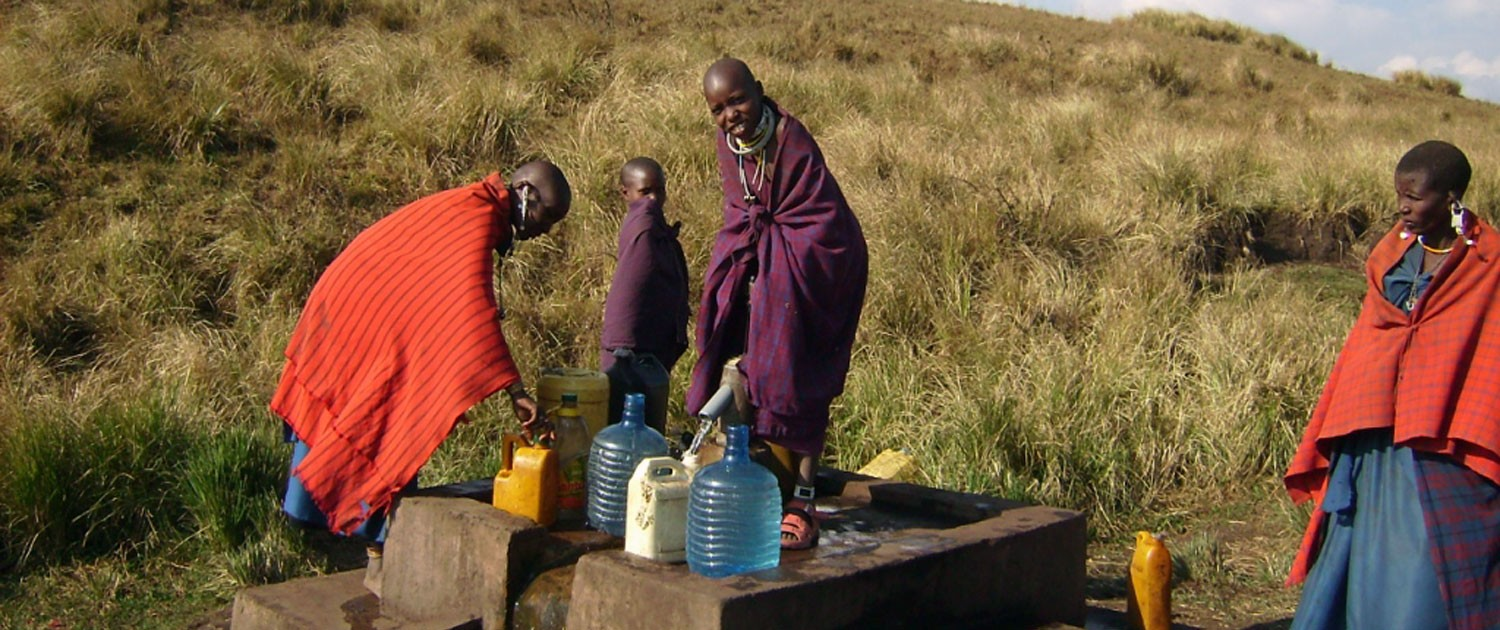

# Tanzania Waterpoint Functionality Classification using Random Forest

Author: **Chi Bui**

## Overview 

Tanzania is in the midst of a water crisis: 4 million people in the country do not have access to a source of safe water, and 30 million people lack access to improved sanitation. People living in such circumstances, particulary women and children, usually bear the responsibility of collecting water in their communities, spending a significant amount of time traveling long distances to collect water several trips each day.

The objective of this project is to use **Random Forest**, a powerful ensemble method to perform a **ternary classification** of the functionality of the water wells in Tanzania.

## Business Problems

Almost half the population of Tanzania is without basic access to safe water. Although there are many waterpoints already established in the country, a lot of them are in need of repair while others have failed altogether. 

The model built in this project could be utilized as one of the first steps in the waterpoint functionality diagnostic process. It can assist the Tanzanian Ministry of Water on identifying pumps that are in need of repair and/or no longer functional. A better understanding of which features might be contributing to waterpoints functionality could help improve maintenance operations, and ensure that safe, clean water becomes available to more people across the country.

## Dataset

The dataset provided on https://www.drivendata.org/ by **Taarifa** and the **Tanzanian Ministry of Water**. More details on the competition could be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/).

Please note that for the actual competition, the use of external data is not allowed. However, I did incorporate data from 2 external sources in my own analysis project. 

### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [387]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (classification_report, accuracy_score, make_scorer, roc_auc_score,
                             confusion_matrix)
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, 
                                   RobustScaler, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from geopy.distance import geodesic
import datetime

%matplotlib inline

### Import data

In [ ]:
directory_to_data = os.path.join('..', '..', 'data')

y = pd.read_csv(os.path.join(directory_to_data, '0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'))
X = pd.read_csv(os.path.join(directory_to_data, '4910797b-ee55-40a7-8668-10efd5c1b960.csv'))

In [604]:
final_test = pd.read_csv(os.path.join(directory_to_data, '702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'))

## Exploratory Data Analysis (EDA)

In [13]:
# CONCAT X AND y TO CREATE 1 MASTER DATAFRAME
df = pd.concat([X, y], axis=1)

# DROP 'id' COLUMNS
df = df.drop(['id'], axis=1)

# DROP DUPLICATED ENTRIES
df.drop_duplicates(keep='first', inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59364 non-null  float64
 1   date_recorded          59364 non-null  object 
 2   funder                 55729 non-null  object 
 3   gps_height             59364 non-null  int64  
 4   installer              55709 non-null  object 
 5   longitude              59364 non-null  float64
 6   latitude               59364 non-null  float64
 7   wpt_name               59364 non-null  object 
 8   num_private            59364 non-null  int64  
 9   basin                  59364 non-null  object 
 10  subvillage             58993 non-null  object 
 11  region                 59364 non-null  object 
 12  region_code            59364 non-null  int64  
 13  district_code          59364 non-null  int64  
 14  lga                    59364 non-null  object 
 15  wa

In [15]:
df.status_group.value_countss()

functional                 32237
non functional             22813
functional needs repair     4314
Name: status_group, dtype: int64

In [17]:
df.status_group.value_counts(normalize=True)

functional                 0.54304
non functional             0.38429
functional needs repair    0.07267
Name: status_group, dtype: float64

The master training set that I would be working with contains 59364 entries and 40 columns, with the target variable being **`status_group`**.

This dataset has some class imbalances that would have to be addressed during modeling. Although this is a ternary dataset, one class `"functional"` takes up 54.3% of the whole training dataset, while `"functional needs repair"` is only 7.2%.

In [18]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227
std,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### `longitude`

The minimum `longitude` in this dataset is 0. Realistically, longitudes for Tanzania should be in the 29-40 range, and definitely should not be lower than 28. Therefore these 0 values in `longitude` are most likely placeholders, and should be treated as missing values later on.

In [614]:
directory_to_img = os.path.join('..', '..', 'images')

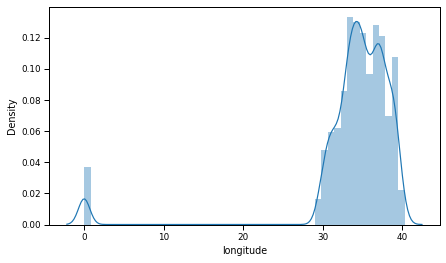

In [643]:
sns.set_context("paper")
plt.figure(figsize=(7,4))
sns.distplot(df.longitude)
plt.savefig(os.path.join(directory_to_img, 'longitude.jpg'), dpi=300, bbox_inches='tight')
fig.show();

### `amount_tsh`

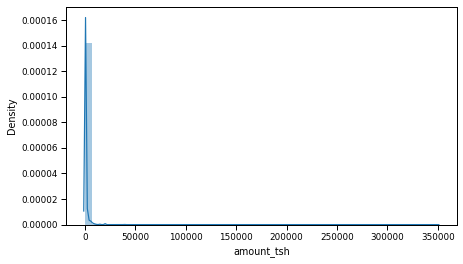

In [644]:
plt.figure(figsize=(7,4))
sns.distplot(df.amount_tsh)
plt.savefig(os.path.join(directory_to_img, 'amount_tsh.jpg'), dpi=300, bbox_inches='tight')
fig.show();

In [28]:
len(df[df.amount_tsh == 0])

41603

In [32]:
df[df.amount_tsh == 0].status_group.value_counts(normalize=True)

functional                 0.473139
non functional             0.453669
functional needs repair    0.073192
Name: status_group, dtype: float64

Around 70% of the values in `amount_tsh` is 0, and the remaining values of this feature spreads very thinly up to 350,000. 

`amount_tsh` is the "Total static head (amount water available to waterpoint)," but yet 47.3% of the wells with `amount_tsh = 0` are still categorized as `functional`. Although this proportion of functional is slightly lower than in the population, it still makes me unsure whether or not `amount_tsh` would be a valuable predictor in our models due to high amount of 0s.

### `gps_height`

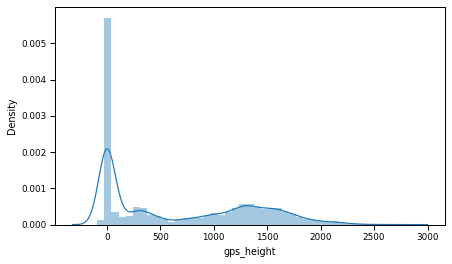

In [645]:
plt.figure(figsize=(7,4))
sns.distplot(df.gps_height)
plt.savefig(os.path.join(directory_to_img, 'gps_height.jpg'), dpi=300, bbox_inches='tight')
fig.show();

In [34]:
len(df[df.gps_height == 0])

20402

In [36]:
len(df[df.gps_height < 0])

1496

0 is also the mode of `gps_height` with approx. 34.3% the dataset. `gps_height` is explained as the "Altitude of the well" and since wells do go underground, it makes sense that 1496 of the datapoints have negative `gps_height`. 

### `num_private`

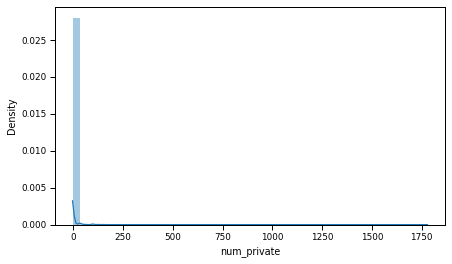

In [646]:
plt.figure(figsize=(7,4))
sns.distplot(df.num_private);

In [40]:
len(df[df.num_private == 0])/len(df)

0.9872481638703592

There is no explanation on this feature on the website. And roughly 98% of the datapoints in our master dataset have `num_private = 0`. Similar to `amount_tsh`'s, the remaining values of this feature also spread very thinly up to 1776. Since I'm not 100% sure what this feature refers to, the lack of variance in this feature's values means that it might not be contributing significantly to the differentiation of the `status_group` classes.  

### `construction_year`

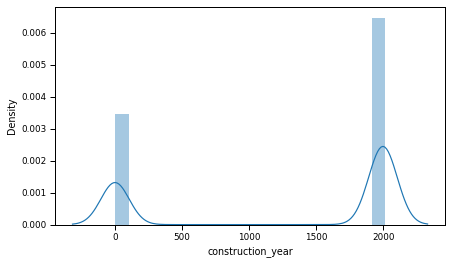

In [647]:
plt.figure(figsize=(7,4))
sns.distplot(df.construction_year);

In [43]:
len(df[df.construction_year == 0])/len(df)

0.3482413583990297

In [45]:
df[df.construction_year != 0].construction_year.describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

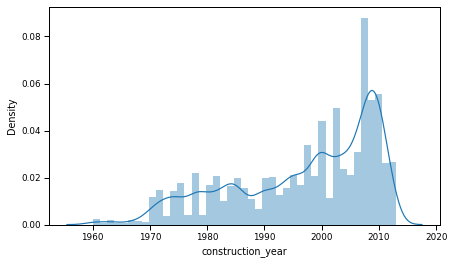

In [648]:
plt.figure(figsize=(7,4))
sns.distplot(df[df.construction_year != 0].construction_year);

34.8% of our dataset has `construction_year = 0`. Focusing on the datapoints with valid construction years, I can see that:
- the oldest well was constructed in 1960 
- and the newest one in 2013 
- 2010 is the year with most amount of wells built
- and the mean value for `construction_year` is 1996

Overall, this looks like a left-skewed normal distribution with median greater than mean.

I would've considered imputing the 0 values in `construction_year` with the median/mean year. However, since 0 takes up such a large proportion of the dataset, I'm not sure what to do with them without altering the overall landscape of this feature.

In [118]:
pd.crosstab(df.construction_year, df.status_group)\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
construction_year,,,
0,10533,1786,8354
2010,2023,90,532
2008,1839,127,647
2009,1774,138,621
2000,1279,136,676
2007,1081,116,390
2011,943,78,235
2006,883,135,453
2003,828,71,387


It appears that generally speaking well pumps' functionality decreases as they get older, which makes sense. Although according to our dataset, a large amount of wells constructed in 2010 still remain `functional` compared to other years, which is not totally unreasonable as the most recent entries were only recorded in 2013, 3 years after 2010.

In [120]:
df[df.year_recorded < df.construction_year][['date_recorded', 'construction_year', 'status_group']]

,date_recorded,construction_year,status_group
8729,2004-05-01,2008,non functional
10441,2004-12-01,2006,non functional
13366,2004-06-01,2011,functional
23373,2004-03-01,2009,functional
27501,2004-01-07,2009,functional
32619,2004-03-01,2005,non functional
33942,2004-03-01,2007,non functional
39559,2004-03-06,2009,non functional
48555,2004-12-01,2008,functional


Also, somehow it seems like there're a few entries that were "recorded" even before they were constructed, all of which were recorded in 2004, which seems strange. This could be data entry error.

### `population`

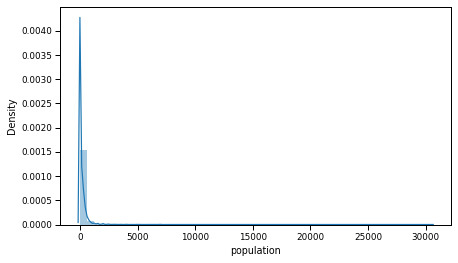

In [650]:
plt.figure(figsize=(7,4))

sns.distplot(df.population);

In [48]:
len(df[df.population == 0])/len(df)

0.3595613503133212

Next, I'll zoom into the population <= 2000 to see how it looks

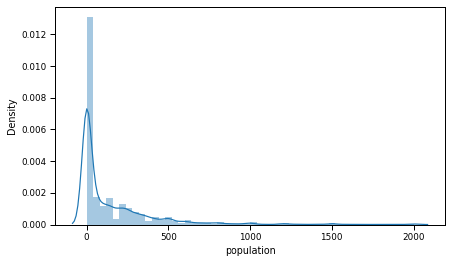

In [651]:
plt.figure(figsize=(7,4))

sns.distplot(df[df.population <= 2000].population);

35.9% of the datapoints have `population = 0`. The remaining only goes as high as 30500. The populations of people living around the wells are relatively small, with the majority being less than 2000. 

One of the biggest challenges I'll have to deal with in this project is definitely the large amount of 0s being used as placeholder for missing data in almost every numerical features. These 0 values also take up large portions of those columns.

### Geospatial data vs `status_group`

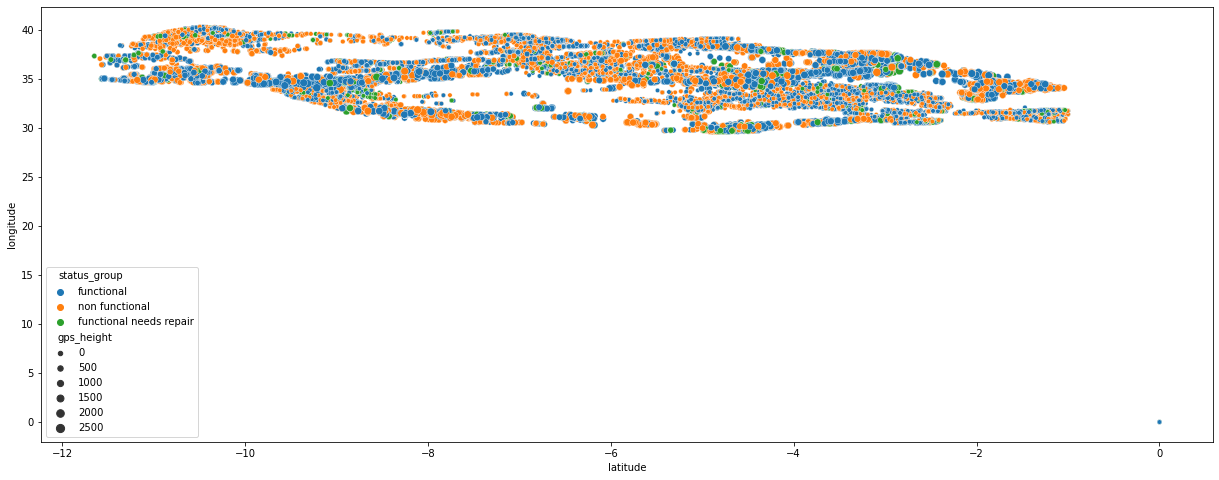

In [197]:
# VISUALIZATION USING SCATTER PLOT
fig, ax = plt.subplots(figsize=(21,8))
sns.scatterplot(data=df, x='latitude', y='longitude', size='gps_height', hue='status_group', ax=ax);

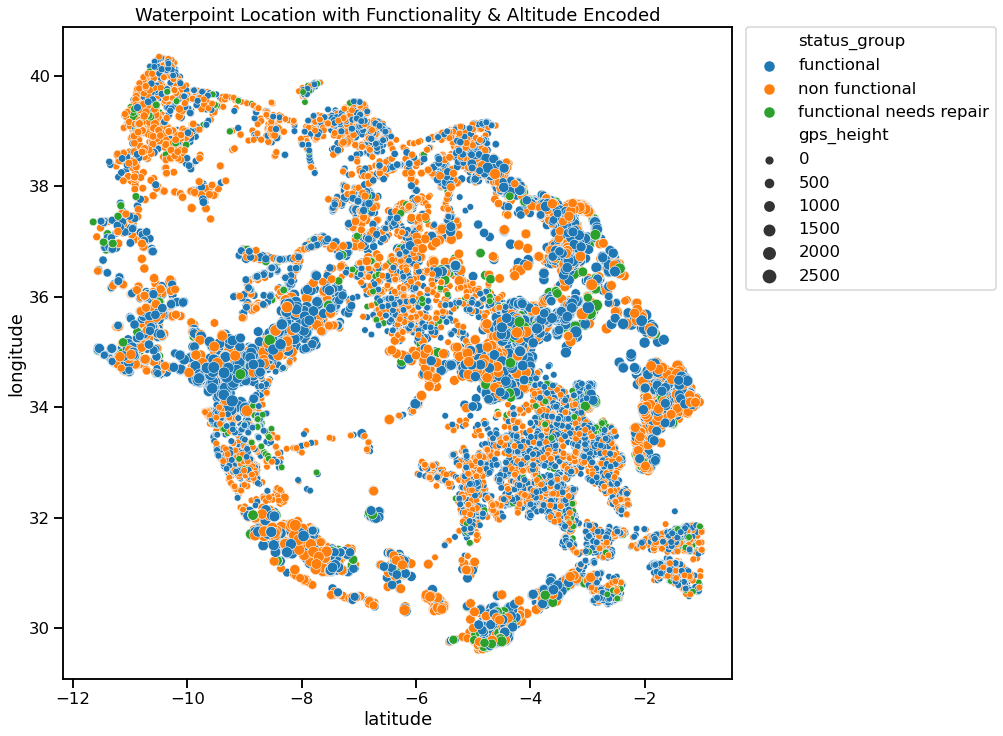

In [652]:
# REMOVING DATAPOINTS WITH longitude = 0
sns.set_context("talk") 

fig, ax = plt.subplots(figsize=(12,12))
ax = sns.scatterplot(data=df[df.longitude >= 25], x='latitude', y='longitude', 
                size='gps_height', hue='status_group', ax=ax)
ax.set_title('Waterpoint Location with Functionality & Altitude Encoded')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(directory_to_img, 'geospatial_scatter.jpg'), bbox_inches='tight');

We can see that waterpoints are more densely distributed in some regions that in others. 
- There seems to be a high amount of `non functional` wells in the Southeast and Northwest regions of Tanzania. 
- Also, there are some large open spaces without any waterpoints being recorded. I'm not sure if this is just a lack of data, or lack of actual wells in these areas, or a combination of both. 

In addition, visually we can also see that more of the "larger" waterpoints (meaning they're higher in altitude `gps_height`) have been recorded as `functional`.    

In [57]:
df.isna().sum()/len(df)

amount_tsh               0.000000
date_recorded            0.000000
funder                   0.061232
gps_height               0.000000
installer                0.061569
longitude                0.000000
latitude                 0.000000
wpt_name                 0.000000
num_private              0.000000
basin                    0.000000
subvillage               0.006250
region                   0.000000
region_code              0.000000
district_code            0.000000
lga                      0.000000
ward                     0.000000
population               0.000000
public_meeting           0.055825
scheme_management        0.065309
scheme_name              0.474008
permit                   0.051479
construction_year        0.000000
extraction_type          0.000000
extraction_type_group    0.000000
extraction_type_class    0.000000
management               0.000000
management_group         0.000000
payment                  0.000000
payment_type             0.000000
water_quality 

Around 6% of `funders` and `installers` values are missing.

`scheme_name` has a very high amount of missing values (around 47.4%), therefore I will most likely not include it in my modeling.

Next, we will look at the contingency tables and visualization between some of these categorical variables and `target_group`

In [80]:
def plot_stackedbar(df, title, figsize):
    colors = ['#5886a5', '#FAC748', '#ff6361']
    labels = list(df.columns)

    fig, ax = plt.subplots(1, figsize=figsize)
    left = len(df) * [0]
    
    for idx, name in enumerate(labels):
        plt.barh(df.index, 
                 df[name], 
                 left=left, 
                 color=colors[idx], 
                 height=0.3)
        left = left + df[name]
        
    # title and subtitle
    plt.title(title, loc='left', fontsize=20, pad=40)
    
    # legend
    plt.legend(labels, 
               bbox_to_anchor=([0.38, 1.1, 0.58, 0]), 
               ncol=3, 
               frameon=True, 
               fontsize=14)
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
    # reset font size for yticks
    ax.tick_params(axis='both', which='major', labelsize=15)
    
plt.show()a

### `region`

In [93]:
pd.crosstab(df.region, df.status_group, normalize='index')\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
region,,,
Iringa,0.782206,0.023234,0.194560
Arusha,0.684776,0.052239,0.262985
Manyara,0.623500,0.060644,0.315856
Kilimanjaro,0.602877,0.073533,0.323590
Pwani,0.590512,0.013662,0.395825
Dar es Salaam,0.572671,0.003727,0.423602
Tanga,0.563801,0.028661,0.407538
Ruvuma,0.560606,0.062121,0.377273
Shinyanga,0.559839,0.127309,0.312851


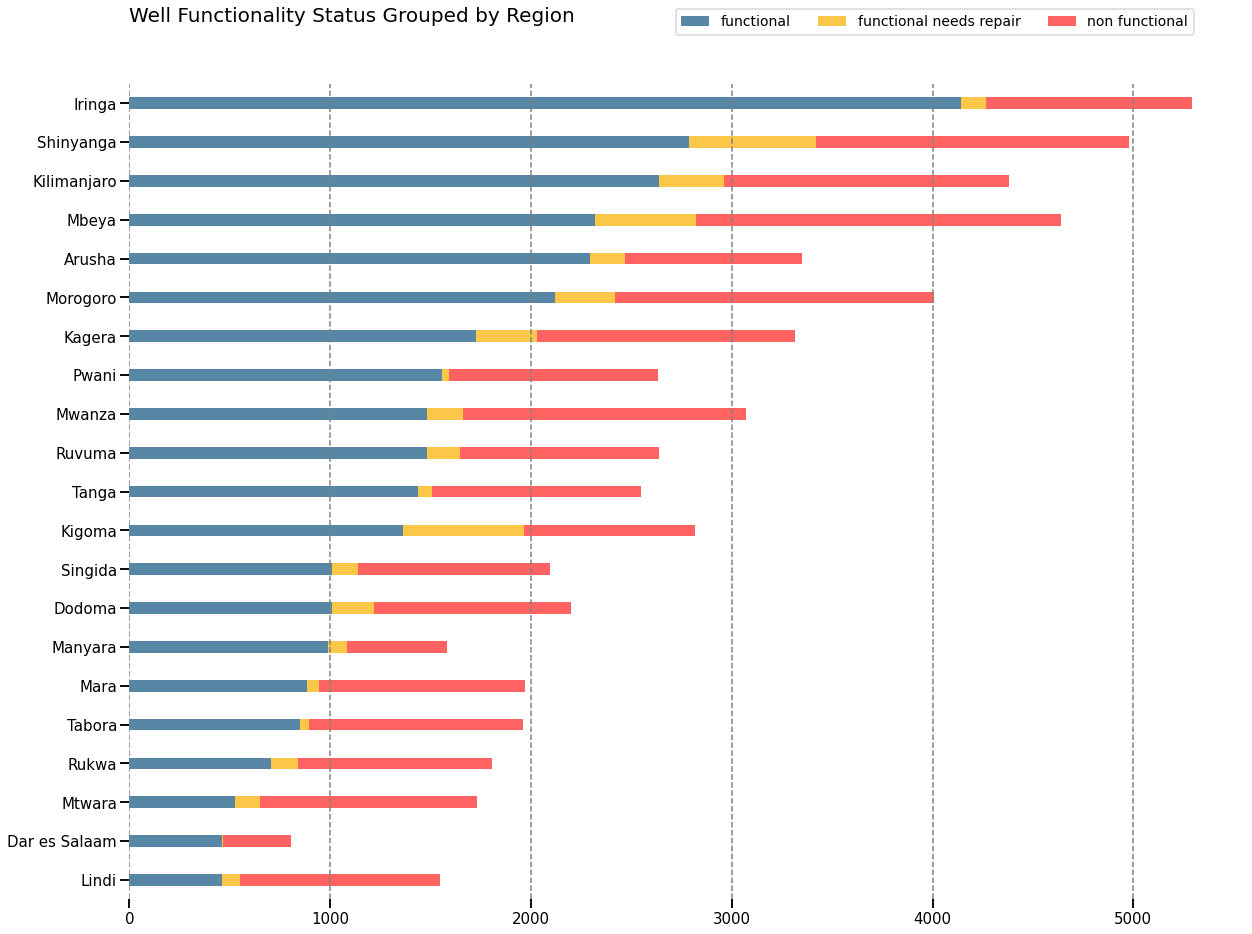

In [653]:
table = pd.crosstab(df.region, df.status_group).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Region\n'

plot_stackedbar(table, title, (20,15))
plt.savefig(os.path.join(directory_to_img, 'stacked_region.jpg'), dpi=300, bbox_inches='tight');

- **Iringa** is on the top in terms of both number of wells and functional wells proportion.
- Largest city and former capital **Dar es Salaam** has the least amount of wells, and also a very small portion of them are identified as `functional needs repair`
- **Lindi** has more wells than **Dar es Salaam**, but yet a very high portion of them are `non functional`. 

We can see there's some sort of relationship between the region/location of the well and its functionality, which does make sense. Wells in certain locations are perhaps receiving better maintenance from the local management, or somehow constructed better by certain installer than others. 

In addition to this, one of the few things that can caused well water contamination is the polution coming from nearby large residential areas, as well as industrial factories, plants, construction sites, etc. 

### `quantity`

In [82]:
pd.crosstab(df.quantity, df.status_group, normalize='index')\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
quantity,,,
enough,0.652344,0.072305,0.275351
seasonal,0.574111,0.102520,0.323370
insufficient,0.523050,0.095906,0.381044
unknown,0.269962,0.017744,0.712294
dry,0.025148,0.005927,0.968925


- The fact that **dry** wells are often `non functional` is not too hard to understand. 

- What I'm also interested in here is the proportion of `non-functional` wells in the **unknown** group is a lot higher than the overall population's. One explanation for this is that wells that receive better management/maintenance are usually also monitored and documented more regularly, which leads to more data available for them. On the other hand, lack of data on some of the wells is an indication that they are perhaps not well taken care of.

This indicates that there is values in the **unknown** here.

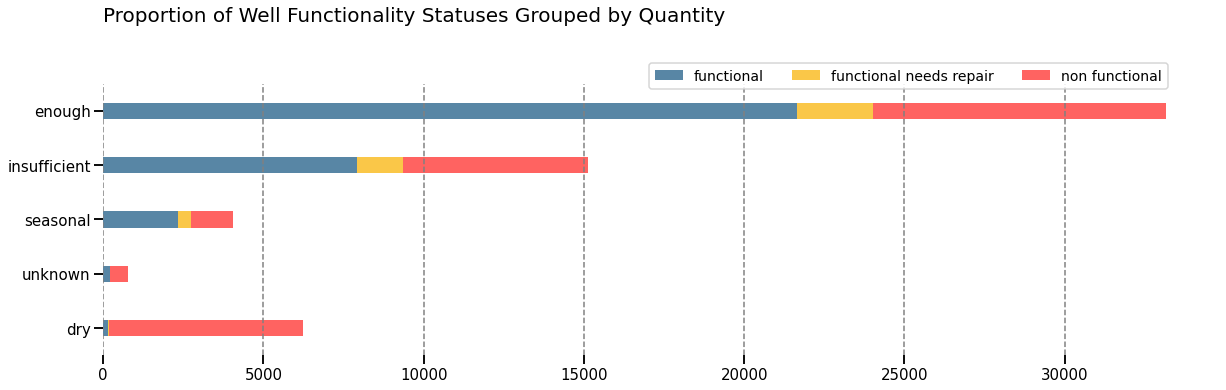

In [654]:
table = pd.crosstab(df.quantity, df.status_group).sort_values(by='functional')
title = 'Proportion of Well Functionality Statuses Grouped by Quantity\n'

plot_stackedbar(table, title, (20,5))
plt.savefig(os.path.join(directory_to_img, 'stacked_quantity.jpg'), dpi=300, bbox_inches='tight');

### `water_quality`

In [88]:
pd.crosstab(df.water_quality, df.status_group, normalize='index')\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
water_quality,,,
fluoride,0.755000,0.065000,0.180000
soft,0.565876,0.076814,0.357310
milky,0.544776,0.017413,0.437811
salty abandoned,0.513274,0.212389,0.274336
coloured,0.502041,0.110204,0.387755
salty,0.457166,0.046334,0.496499
fluoride abandoned,0.352941,0.000000,0.647059
unknown,0.140950,0.018687,0.840363


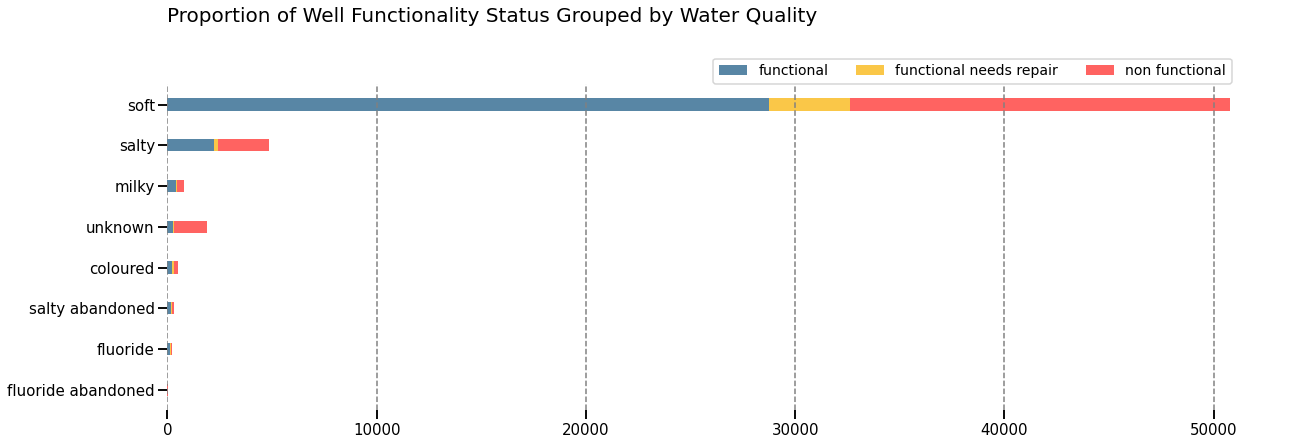

In [655]:
table = pd.crosstab(df.water_quality, df.status_group).sort_values(by='functional')
title = 'Proportion of Well Functionality Status Grouped by Water Quality\n'

plot_stackedbar(table, title, (20,6))
plt.savefig(os.path.join(directory_to_img, 'stacked_quality.jpg'), dpi=300, bbox_inches='tight');

Again, similar to `quantity`, the percentage of `non functional` in the **unknown** group is a lot higher than the others.

### `extraction_type`

In [96]:
pd.crosstab(df.extraction_type_class, df.status_group, normalize='index')\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
extraction_type_class,,,
rope pump,0.649667,0.037694,0.312639
handpump,0.630340,0.060424,0.309237
gravity,0.599268,0.100837,0.299895
submersible,0.538723,0.040992,0.420285
wind-powered,0.427350,0.059829,0.512821
motorpump,0.379980,0.046200,0.573820
other,0.160106,0.032052,0.807842


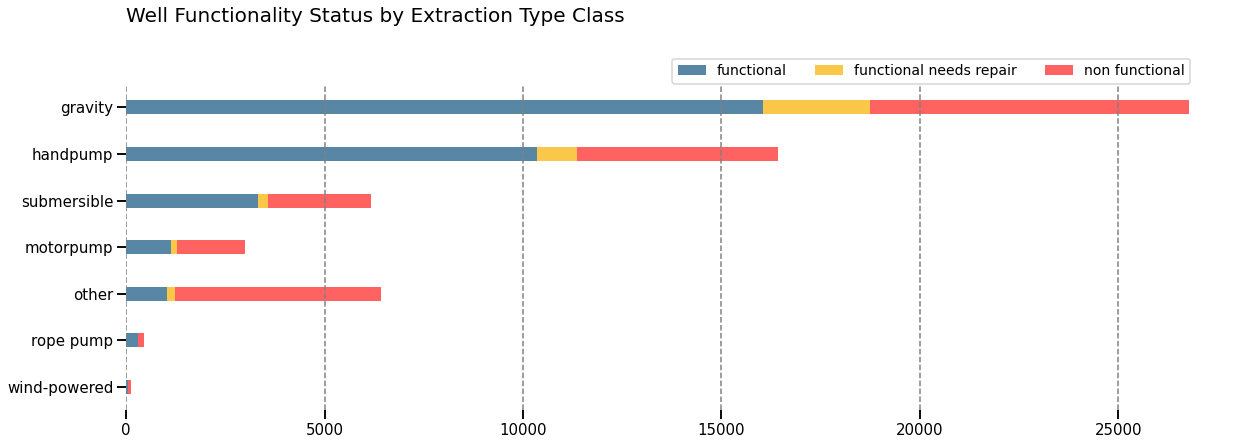

In [656]:
table = pd.crosstab(df.extraction_type_class, df.status_group).sort_values(by='functional')
title = 'Well Functionality Status by Extraction Type Class\n'

plot_stackedbar(table, title, (20,6))
plt.savefig(os.path.join(directory_to_img, 'stacked_extract.jpg'), dpi=300, bbox_inches='tight');

- **rose_pump** appears to have a higher than average proportion of `functional` wells of approx. **65%**
- while **other** has a very high percentage of `non functional` waterpoints of **80.7%**

### `basin`

In [100]:
pd.crosstab(df.basin, df.status_group, normalize='index')\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
basin,,,
Lake Nyasa,0.653687,0.049164,0.297148
Rufiji,0.635406,0.054789,0.309804
Pangani,0.600895,0.053356,0.345749
Internal,0.575723,0.071548,0.352730
Wami / Ruvu,0.523802,0.044931,0.431268
Lake Victoria,0.497258,0.096553,0.406189
Lake Tanganyika,0.483053,0.115361,0.401586
Lake Rukwa,0.407498,0.110024,0.482478
Ruvuma / Southern Coast,0.371689,0.072557,0.555753


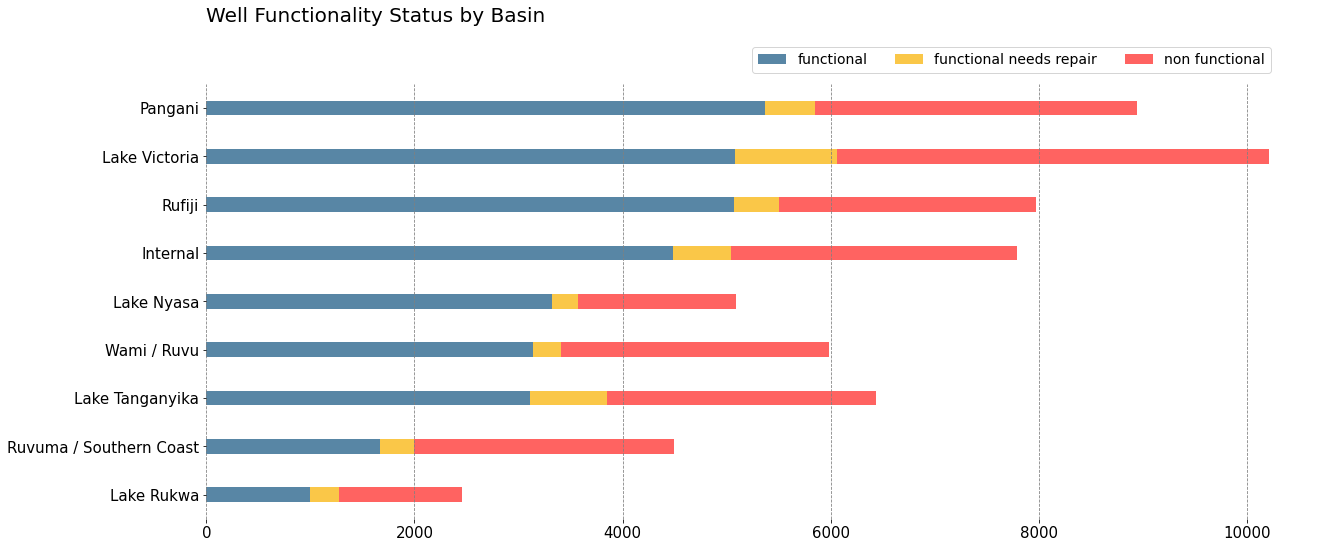

In [103]:
table = pd.crosstab(df.basin, df.status_group).sort_values(by='functional')
title = 'Well Functionality Status by Basin\n'

plot_stackedbar(table, title, (20,8))

- **Lake Nyasa** does not have the most amount of wells, however it has the highest percentage of functional wells.
- On the other hand, **Ruvuma / Southern Coast** seems to have the highest proportion of `non functional` with just slightly less wells than **Lake Nyasa**

### `waterpoint_type`

In [658]:
wpt_table = pd.crosstab(df.waterpoint_type, df.status_group, normalize='index')\
                        .sort_values(by='functional', ascending=False)
wpt_table

status_group,functional,functional needs repair,non functional
waterpoint_type,,,
dam,0.857143,0.000000,0.142857
cattle trough,0.724138,0.017241,0.258621
improved spring,0.717752,0.108557,0.173691
communal standpipe,0.621476,0.079219,0.299306
hand pump,0.617714,0.058800,0.323486
communal standpipe multiple,0.366290,0.106247,0.527464
other,0.131723,0.045946,0.822330


In [661]:
print(wpt_table.to_markdown())

| waterpoint_type             |   functional |   functional needs repair |   non functional |
|:----------------------------|-------------:|--------------------------:|-----------------:|
| dam                         |     0.857143 |                 0         |         0.142857 |
| cattle trough               |     0.724138 |                 0.0172414 |         0.258621 |
| improved spring             |     0.717752 |                 0.108557  |         0.173691 |
| communal standpipe          |     0.621476 |                 0.0792187 |         0.299306 |
| hand pump                   |     0.617714 |                 0.0588    |         0.323486 |
| communal standpipe multiple |     0.36629  |                 0.106247  |         0.527464 |
| other                       |     0.131723 |                 0.0459464 |         0.82233  |


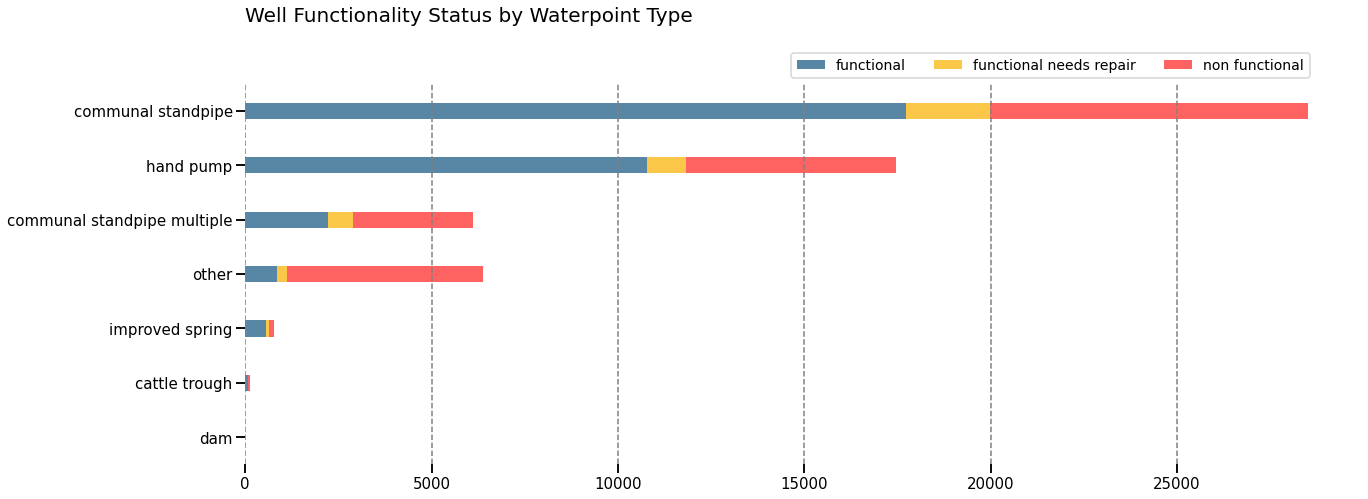

In [657]:
table = pd.crosstab(df.waterpoint_type, df.status_group).sort_values(by='functional')
title = 'Well Functionality Status by Waterpoint Type\n'

plot_stackedbar(table, title, (20,7))
plt.savefig(os.path.join(directory_to_img, 'stacked_wpt_type.jpg'), dpi=300, bbox_inches='tight');

- In this case, looking at the normalized version of the contingency table alone could be misleading. **dam** and **cattle trough** have a very high percentage of `functional` wells; however, in the grand scheme of things, there're not really that many wells in these 2 groups altogether.
- What I find interesting here is the proportions of `non functionnal` in the 2 groups **other** (82%) and **communal standpipe multiple** (52%) which are a lot higher than the population's percentage of `non functional` (38%).

### `source`

In [113]:
pd.crosstab(df.source, df.status_group, normalize='index')\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
source,,,
spring,0.622268,0.074971,0.302761
rainwater harvesting,0.604012,0.136502,0.259485
other,0.597156,0.004739,0.398104
hand dtw,0.568650,0.019451,0.411899
river,0.568560,0.127029,0.304411
shallow well,0.494554,0.056842,0.448604
machine dbh,0.489385,0.044358,0.466257
unknown,0.484848,0.060606,0.454545
dam,0.386260,0.036641,0.577099


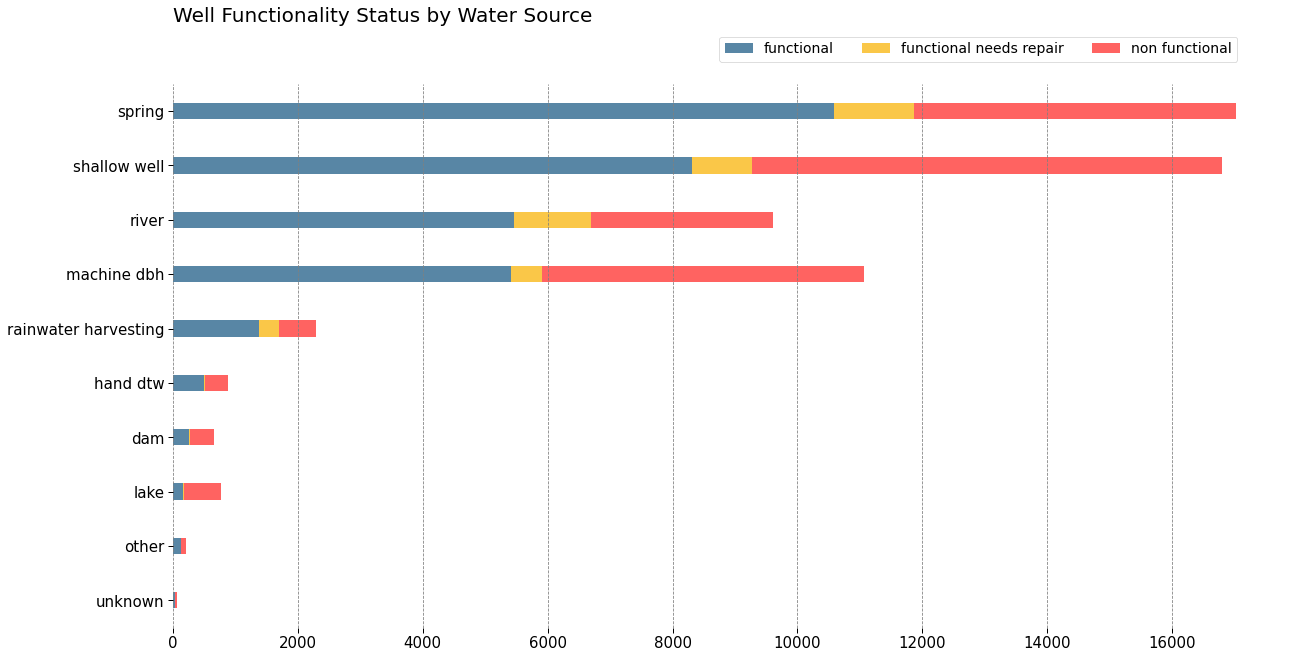

In [450]:
table = pd.crosstab(df.source, df.status_group).sort_values(by='functional')
title = 'Well Functionality Status by Water Source\n'

plot_stackedbar(table, title, (20,10))

- There are a significant amount of wells in the **shallow well**; and the percentage of `non functional` in this group is higher than average (44.8% compared to 38%).
- **rainwater harvesting** does not have too many wells, yet the percentage of `functional` well here is relatively high (60% compare to the average of 53%).

### `date_recorded`

The proportions of well functionality in **rainwater harvesting** has led me to think that perhaps the functionality of the wells are also partially impacted by when the inspection/measurement was recorded. I'll extract the month & year from `date_recorded` to create new columns to see if there's any potential relationship between the record time and outcome.

In [108]:
df.date_recorded = pd.to_datetime(df.date_recorded)
df['month_recorded'] = df.date_recorded.dt.month_name().str.slice(stop=3)
df['year_recorded'] = df.date_recorded.dt.year 

In [109]:
pd.crosstab(df.month_recorded, df.status_group, normalize='index')\
        .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
month_recorded,,,
Jun,0.780347,0.026012,0.193642
Sep,0.652439,0.030488,0.317073
Mar,0.616525,0.050178,0.333296
May,0.601190,0.029762,0.369048
Dec,0.587762,0.033816,0.378422
Feb,0.551997,0.075272,0.372731
Apr,0.516373,0.110327,0.373300
Aug,0.511303,0.075253,0.413444
Oct,0.509351,0.057756,0.432893


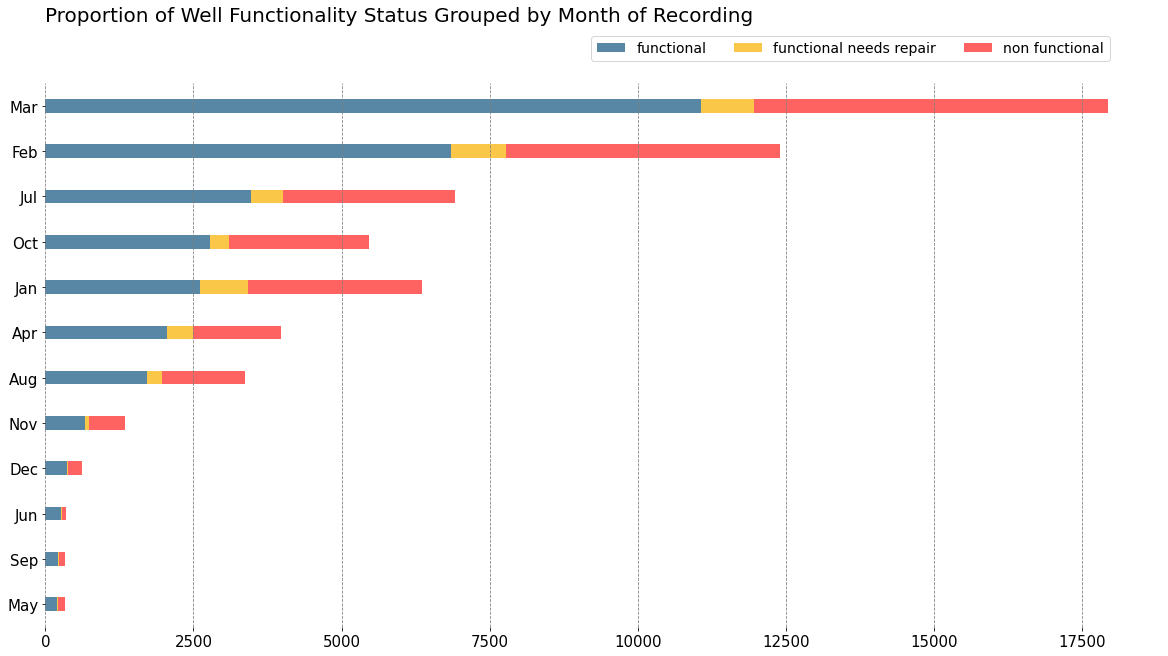

In [111]:
month_tab = pd.crosstab(df.month_recorded, df.status_group).sort_values(by='functional')
title = 'Proportion of Well Functionality Status Grouped by Month of Recording\n'

plot_stackedbar(month_tab, title, (20,10))

In [117]:
pd.crosstab(df.month_recorded, df.quantity, normalize='index')\
        .sort_values(by='dry', ascending=False)

quantity,dry,enough,insufficient,seasonal,unknown
month_recorded,,,,,
Sep,0.201220,0.554878,0.210366,0.030488,0.003049
Dec,0.198068,0.581320,0.183575,0.035427,0.001610
Jan,0.170997,0.534719,0.193985,0.070698,0.029602
Jul,0.136186,0.555009,0.247940,0.048142,0.012722
Nov,0.109050,0.547478,0.217359,0.100890,0.025223
Aug,0.106782,0.531826,0.262344,0.083284,0.015764
Feb,0.100040,0.574264,0.263171,0.052360,0.010165
Oct,0.091676,0.566373,0.217088,0.112028,0.012835
Apr,0.088917,0.551134,0.218136,0.137028,0.004786


I think it's not coincident that **June** appears to record the highest amount of `functional` wells, and lowest amount of **dry** wells. Although Tanzania is a very big country, and the climate does vary considerably within it, generally, the main long rainy season lasts during **March**, **April**, and **May**.  

Overall, this EDA has shown that there are certainly values in the **`unknown`**s and **`other`**s of this dataset. Therefore, for all the categorical variables with missing values to be included in modeling, I will impute them with the string **`"NaN"`** instead of dropping them.

### `region` vs. `region_code`

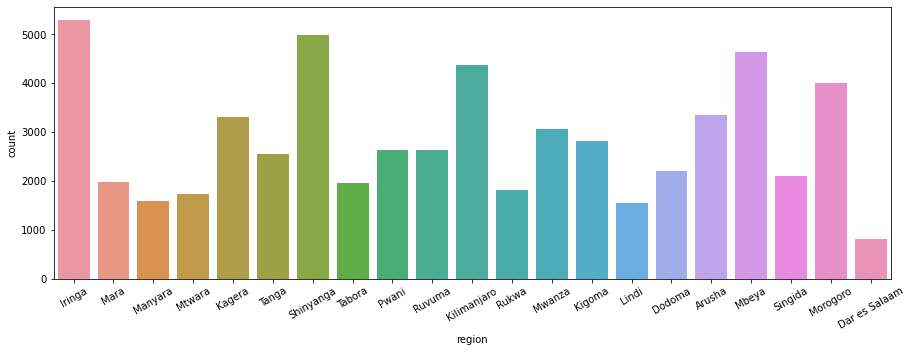

In [185]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(df.region)
ax.set_xticklabels(labels=df.region.unique(), rotation=30);

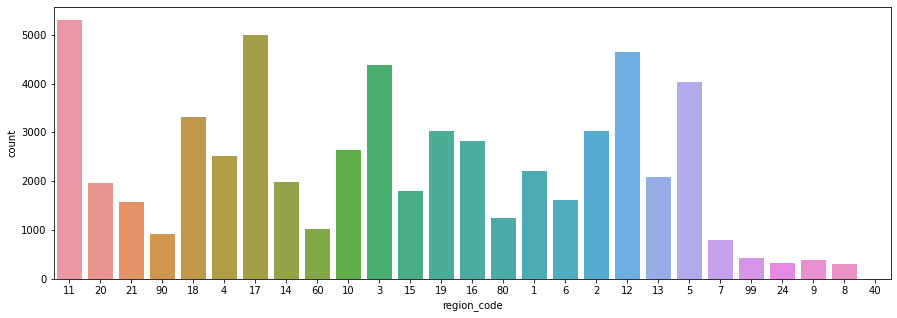

In [186]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(df.region_code);

There are 21 unique values in `region` and 27 in `region_code`, which I'm not sure why. It maybe because some regions are larger and therefore divided up into smaller sub-regions with different codes.

### Correlation

In [121]:
# Convert labels (status_group) to numerical using LabelEncoder
le = LabelEncoder()
le.fit(df.status_group)
le.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

- **0 = functional**
- **1 = functional needs repair**
- **2 = non functional**

Higher values of encoded status indicates higher levels of non-functionality.

In [122]:
# TRANFORM status_group AND SAVE IT AS status_encoded
df['status_encoded'] = le.transform(df.status_group)

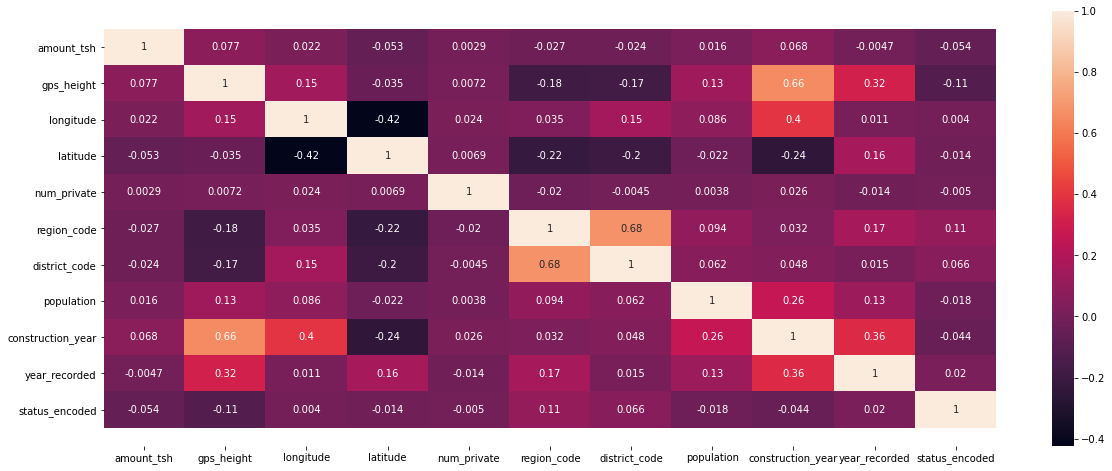

In [124]:
corr = df.corr()
fig, ax = plt.subplots(1, figsize=(20,8))
ax = sns.heatmap(corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

- There appears to be some correlation between geospatial data (`longitude`/`latitude`/`gps_height`) and `year_/age_recorded` as well as `construction_year`.

- Two of the features with highest correlation with `status_encoded` are `gps_height`(negative) and `region_code` (positive):
    - This means that more `functional` have been found at higher `gps_height` altitude (which corresponds nicely with the scatterplot visualization above).

- Also, `year_recorded` also seems to be positively correlated to `region_code`, which may indicates the recording were done by regions.

Although, using `region_code` would reduce interpretability as the information on how these region were coded is unknown.

# Modeling

I would start with the raw data again without any of the tranformations, feature addition done above.

In [506]:
# CONCAT X AND y TO CREATE 1 MASTER DATAFRAME
df = pd.concat([X, y], axis=1)

# DROP SOME COLUMNS
df = df.drop(['recorded_by', 'id'], axis=1)

# DROP DUPLICATED ENTRIES
df.drop_duplicates(keep='first', inplace=True)

### Metrics

The main metric that I would be using to access my models' performance here is **Accuracy Score**. However, for this specific problem, we would also want to be able to identify non-operational waterpoints as well as those that are in need of repair early on, to help the Tanzanian Ministry of Water dispense resources and labors accordingly. Therefore, I would also be looking at **Recall Score** particularly of the 2 classes `non functional` and `functional needs repair`.

## Train Test Split

The goal here is to have 3 sets of data:
1. **Training** `X_tt` - used for training
2. **Validation** `X_val` - used for model selection/tuning/tweaking
3. **Testing** `X_test` - used for testing

In [507]:
X_master = df.drop('status_group', axis=1)
y_master = df.status_group

### 1. Master Training Set & Testing Set

In [508]:
# SPLIT 1:
X_train, X_test, y_train, y_test = train_test_split(X_master, y_master, random_state=2021)

In [509]:
print(f'Master Training Set:\t {X_train.shape} | {y_train.shape}')
print(f'Testing Set:\t\t {X_test.shape} | {y_test.shape}')

Master Training Set:	 (44523, 38) | (44523,)
Testing Set:		 (14841, 38) | (14841,)


### 2. Training Set & Validation Set (split from the Master Training Set)

In [510]:
# SPLIT 2:
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, random_state=2021)

In [511]:
print(f'Training:\t {X_tt.shape} | {y_tt.shape}')
print(f'Validation:\t {X_val.shape} | {y_val.shape}')

Training:	 (33392, 38) | (33392,)
Validation:	 (11131, 38) | (11131,)


In [512]:
# MAKING COPIES OF THESE DATASETS FOR TESTING WITH random_feature LATER
X_tt_2 = X_tt.copy()
X_val_2 = X_val.copy()
y_tt_2 = y_tt.copy()
y_val_2 = y_val.copy()

In [513]:
# MAKING COPIES OF DATASETS FOR COMPETITION MODELING 
X_tt_comp = X_tt.copy()
X_val_comp = X_val.copy()
y_tt_comp = y_tt.copy()
y_val_comp = y_val.copy()

X_train_comp = X_train.copy()
X_test_comp = X_test.copy()
y_train_comp = y_train.copy()
y_test_comp = y_test.copy()

## Building Preprocessing Pipeline

This dataset contains groups of features that indicate similar features of the wells, such as:
- `extraction_type`, `extraction_type_group`, and `extraction_type_class`
- `water_quality` and `quality_group`
- `quantity` and `quantity_group` (although further investigating on these 2 features shows that they actually store the exact same information)
- `source`, `source_type`, `source_type_class`
- `waterpoint_type` and `waterpoint_type_group`
- `payment` and `payment_type`

Focusing on the more specific categories would lead to the models containing too many features and slow down runtimes; while these more specific variables might not necessarily offer more values than the general ones. Therefore, for this model, I would only focus on the most generalized features in each of these group instead of including all of them. For example:
- Among `extraction_type`, `extraction_type_group`, and `extraction_type_class`, I would go with `extraction_type_class`
- Between `waterpoint_type` and `waterpoint_type_group`, I would choose `waterpoint_type_group`

### 1. Add Extra Features

#### 1.2. Extract Month/Year and Age Recorded Information from `date_recorded`

In [136]:
class DateTransformer(BaseEstimator, TransformerMixin):
    """Extracts information from datetime column to create new features

    Returns:
        - month_recorded: first 3 character of name of the month recorded
        - year_recorded: four-digit year
        - age_recorded: difference between construction year and year recorded
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['date_recorded'] = pd.to_datetime(X['date_recorded'])
        X['month_recorded'] = X.date_recorded.dt.month_name().str.slice(stop=3)
        X['year_recorded'] = X.date_recorded.dt.year
        X['age_recorded'] = X['year_recorded'] - X['construction_year']
        return self

#### 1.3. Adding Extra Features Regarding Big Cities

Although the competition itself does not allow the use of external data, I think there are meaningful ways we can incorporate external data into improving the overall predictive power and interpretability of the models here, especially when there is such a large amount of missing information in this dataset. 

Therefore, I would use external data my own study, and then remove this transformation from the pipeline when making predictions on testing data for the competition. 

In [616]:
directory_to_tz_cities = os.path.join('..', '..', 'notebook', 'tanzania_cities')

In [617]:
tz_pop_above100k = pd.read_pickle(os.path.join(directory_to_tz_cities, 'tanzania_big_cities.pkl'))

In [138]:
def closest_point(x):
    '''
    Returns: a tuple
        - tuple[0]: name of nearest big city (population over 100000)
        - tuple[1]: geodesic distance from point x to nearest big city (tuple[0])
    '''
    
    output = None
    for _, city in tz_pop_above100k.iterrows():
        distance = geodesic(x, city.coordinates).km
        city_name = city.city
        if (output is None) or (distance < output[1]):
            output = (city_name, distance)
    return output

In [179]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    """Generate extra features from wells' coordinates
    
    Returns:
        - nearest_big_city_name: name of the nearest city with population over 100,000
        - nearest_big_city_distance: distance to nearest city with population over 100,000
        - nearest_big_city_population: population of nearest big city
    """
   
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        names = []
        distances = []
        populations = []
        for idx, row in X.iterrows():
            coordinates = (row['latitude'], row['longitude'])
            n, d = closest_point(coordinates)
            p = tz_pop_above100k[tz_pop_above100k.city == n].population_2021.values[0]
            names.append(n)
            distances.append(d)
            populations.append(p)
        X['nearest_big_city_name'] = names
        X['nearest_big_city_distance'] = distances
        X['nearest_big_city_population'] = populations
        return self

### 2. Preprocessing

#### 2.1. Fill in missing values with string `"NaN"` in some Categorical & Boolean Variables

`public_meeting`, `scheme_management`, `permit`

In [170]:
class NaNImputer(BaseEstimator, TransformerMixin):
    """
    Replaces missing values np.nan with the string "NaN"
    in 3 features 'public_meeting', 'scheme_management', and 'permit'
    """
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        to_fillna = ['public_meeting', 'scheme_management', 'permit']
        X[to_fillna] = X[to_fillna].fillna(value='NaN')
        X[to_fillna] = X[to_fillna].astype(str)  
        return X

#### 2.2. Impute Longitude

The goal of this step is to replace 0 values in longitudes with the aggregated means by region using `region_code`. The main reason I am using `region_code` as the groupby feature is purely because there are more unique values in `region_code` than in `region`.

In [165]:
class LongitudeImputer(BaseEstimator, TransformerMixin):
    """
        Replaces invalid longitude value (0) with the aggregated means by region
        using region_code
    """
    def __init__(self):
        super().__init__()
        self.lng_means_ = {}

    def fit(self, X, y=None):
        self.lng_means_ = X.groupby(['region_code']).longitude.mean()
        return self

    def transform(self, X, y=None):
        # replace 0 with average longitude
        for key, value in self.lng_means_.items():
            X.loc[((X.longitude == 0) & (X.region_code == key)), 'longitude'] = value
        return X

#### 2.3. Binning `funder` & `installer` into 2 groups **major** and **minor**

Each of these 2 variables contains over 1000 possible categories, which means that if I were to include them all as is into the model, I would end up with over 4000 features after One Hot Encoding. One way to deal with high-cardinality in these 2 variables is by binning them into bigger groups:

- **major** - top 100 funders or installers - responsible for around 80% of the water wells in the dataset used for fitting
- **minor** - any entities that are not in the top 100 list

##### 2.3.1. Funder

In [167]:
class FunderBinner(BaseEstimator, TransformerMixin):
    """
    Categorize funders into 2 groups 'major' or minor'
    - 'major': top 100 funders in the fitted dataset
    - 'minor' - any entities that are not in the top 100 list
    """

    def __init__(self):
        super().__init__()
        self.top_100_funder = []

    def fit(self, X, y=None):
        self.top_100_funder = X.funder.value_counts()[:100].index
        return self

    def transform(self, X, y=None):
        for idx, row in X.iterrows():
            if row['funder'] in self.top_100_funder:
                val = 'major' 
            else:
                val = 'minor'
            X.loc[idx, 'funder'] = val
        return X

##### 2.3.2. Installer

In [168]:
class InstallerBinner(BaseEstimator, TransformerMixin):
    """
    Categorize installers into 2 groups 'major' or minor'
    - 'major': top 100 funders in the fitted dataset
    - 'minor' - any entities that are not in the top 100 list
    """

    def __init__(self):
        super().__init__()
        self.top_100_installer = []

    def fit(self, X, y=None):
        self.top_100_installer = X.installer.value_counts()[:100].index

        return self

    def transform(self, X, y=None):
        for idx, row in X.iterrows():
            if row['installer'] in self.top_100_installer:
                val = 'major' 
            else:
                val = 'minor'
            X.loc[idx, 'installer'] = val
        return X

#### 2.4. Scaling Numerical Features

- Scaling Longitude and Latitude are especially important here because they're on different scales.
- From experiments with different scalers, `MinMaxScaler()` was found to be the one that yields better results compared to other types of scaling (including `StandardScaler()`, `RobustScaler()`, and `PowerTransformer()`).

In [169]:
# SELECT NUMERICAL FEATURES TO BE INCLUDED IN MODELING
numerical_features = ['amount_tsh', 'gps_height', 'num_private', 'construction_year', 'year_recorded', 
                      'age_recorded', 'population', 'nearest_big_city_population', 'longitude', 
                      'latitude', 'nearest_big_city_distance']

In [171]:
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

#### 2.5. One Hot Encoding Categorical Features

In [173]:
# SELECT CATEGORICAL FEATURES TO BE INCLUDED IN MODELING
categorical_features = ['funder', 'installer', 'basin', 'region', 'public_meeting', 'scheme_management',
                        'permit', 'extraction_type_class', 'management_group', 'payment_type', 
                        'quality_group', 'quantity', 'source_class', 'waterpoint_type_group', 
                        'nearest_big_city_name', 'month_recorded']

In [174]:
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

## Preprocessing Pipeline

In [354]:
# ADDING NEW FEATURES USING FeatureUnion
union = FeatureUnion(transformer_list=[('recorded', DateTransformer()),
                                       ('nearest_big_city', FeatureGenerator())])

# TRANSFORM NUMERICAL & CATEGORICAL FEATURES SEPARATELY USING ColumnTransformer
col_tranformer = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                                 ('cat', categorical_transformer, categorical_features)],
                                   remainder='drop')

# STACKING THEM TOGETHER IN A PIPELINE
preprocessor = Pipeline(steps=[('fillna', NaNImputer()),
                               ('lng_imp', LongitudeImputer()),
                               ('funder', FunderBinner()),
                               ('installer', InstallerBinner()),
                               ('col_tf', col_tranformer)])

## Random Forest Classifier

After experimenting with different algorithms and hyperparameter tuning techniques, I would go with **RandomForestClassifier** because so far it the highest overall accuracy score. In addition, Random Forest are robust, can generalize well, and overall more interpretable than some of the other algorithms. 

In [176]:
def classification_report_with_accuracy_score(y_true, y_pred):
    """
    Returns Accuracy score while also printing out Classification Report
    """
    
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

scr_accuracy = make_scorer(classification_report_with_accuracy_score)

### Random Forest with Class Imbalance

In [284]:
# CREATE NEW FEATURES IN TRAINING SET X_tt
union.fit_transform(X_tt)

array([DateTransformer(), FeatureGenerator()], dtype=object)

In [187]:
# STACKING preprocessor AND RandomForestClassifier() INTO A PIPELINE
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestClassifier(random_state=2021))])

scores_rf1 = cross_val_score(pipeline, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.86      0.83      3623
functional needs repair       0.49      0.33      0.40       483
         non functional       0.80      0.77      0.78      2573

               accuracy                           0.79      6679
              macro avg       0.70      0.65      0.67      6679
           weighted avg       0.78      0.79      0.78      6679

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.84      3623
functional needs repair       0.52      0.31      0.39       483
         non functional       0.81      0.78      0.80      2573

               accuracy                           0.80      6679
              macro avg       0.71      0.66      0.68      6679
           weighted avg       0.79      0.80      0.79      6679

                         precision    recall  f1-score   support

             funct

In [193]:
print(f'Cross Validation Accuracy Scores: {scores_rf1}')
print()
print(f'Average Accuracy: {scores_rf1.mean()}')

Cross Validation Accuracy Scores: [0.78514748 0.79532864 0.7949985  0.79035639 0.78885894]

Average Accuracy: 0.7909379911315011


We can see that on average, Recall Score on the `functional needs repair` class is very low (averaging 32%). Recall Score for a certain class is the percentage of that class in actual obervations being correctly identified by the model. This low Recall score means that this model is still mis-classifying a lot of `functional needs repair` as the other 2 classes.

The model has such a poor performance on this class compared to the other 2 perhaps due to less exposure to the `functional needs repair`. 

Next, I would look at countering Class Imbalance by using SMOTE to synthesize new examples by oversampling imbalanced set.

### Random Forest with SMOTE

In [315]:
# STACKING PREPROCESSOR TRANSFORMATIONS, SMOTE() AND RandomForestClassifier() 
# INTO AM IMBALANCE PIPELINE
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, 
                                         sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021))])

In [291]:
scores_rf2 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.82      3623
functional needs repair       0.41      0.44      0.42       483
         non functional       0.81      0.76      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.68      0.68      6679
           weighted avg       0.78      0.78      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      3623
functional needs repair       0.40      0.42      0.41       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.68      0.68      6679
           weighted avg       0.78      0.78      0.78      6679

                         precision    recall  f1-score   support

             funct

In [292]:
print(f'Cross Validation Accuracy Scores: {scores_rf2}')
print()
print(f'Average Accuracy: {scores_rf2.mean()}')

Cross Validation Accuracy Scores: [0.77826022 0.78290163 0.78137167 0.77747829 0.77942498]

Average Accuracy: 0.7798873566381979


In [293]:
scores_rf1.mean() - scores_rf2.mean()

0.011050634493303235

Overall, average accuracy score has dropped by 1.1%. Although this is not to big of a difference, the print out of classification reports show that the Recall Score for `functional needs repair` has improved (from 32% to 42%). Although this is relatively pretty modest, it's indicating that the new model has accurately identified more of the `functional needs repair` wells.

A slight drop in accuracy after oversampling means that the model perhaps still has not learned to differentiate the classes very well. Since `functional needs repair` is so under-represented, it was able to achieve higher accuracy score in the first model purely by predicting more of the other 2 classes without actually picking up the differences among them. 

Between the 2 models `rf1` and `rf2` I would go with the second one, because it performs better on the less represented class, and thus offers more meaning than the first model.

## Model Evaluation

In [320]:
# FIT MODEL ON THE TRAINING DATASET X_tt and y_tt
rf2 = pipe_sm.fit(X_tt, y_tt)

In [211]:
# MAKE PREDICTIONS ON THE TRAINING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_tt_pred = rf2.predict(X_tt)
print(classification_report(y_tt, y_tt_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      1.00     18112
functional needs repair       0.95      0.99      0.97      2412
         non functional       1.00      1.00      1.00     12868

               accuracy                           0.99     33392
              macro avg       0.98      0.99      0.99     33392
           weighted avg       0.99      0.99      0.99     33392



In [214]:
# CREATE NEW FEATURES IN VALIDATION SET X_val
union.fit_transform(X_val)

# MAKE PREDICTIONS ON THE VALIDATION DATASET 
y_val_pred = rf2.predict(X_val)
print(classification_report(y_val, y_val_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      6038
functional needs repair       0.40      0.47      0.43       819
         non functional       0.83      0.77      0.80      4274

               accuracy                           0.79     11131
              macro avg       0.68      0.69      0.69     11131
           weighted avg       0.79      0.79      0.79     11131



After being trained on the whole `X_tt` dataset, the model performs slightly better with an accuracy score of 79%. However, compared to the accuracy score on the training set (99%), this is still lower by 20%, which means that the model is **overfitting** to the training data, and is picking up too much of the on the random noises of the training data. 

In order to fight overfitting, I would then look into reducing the overall number of features by only keeping the ones that seem to make the most impact on our target variable. 

#### Confusion Matrix

In [402]:
labels = y_tt.unique()
confusion_matx_tt = confusion_matrix(y_tt, y_tt_pred, labels=labels)
confusion_matx_tt

array([[17984,    18,   110],
       [   20, 12838,    10],
       [   23,     1,  2388]])

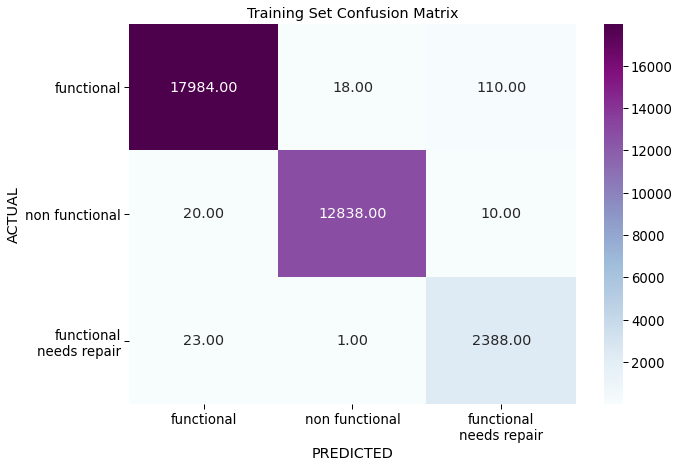

In [447]:
df_cm = pd.DataFrame(confusion_matx_tt, index=labels, columns=labels)
sns.set_context("paper", font_scale=1.5)  
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt=".2f", cmap="BuPu")
ax.set(title="Training Set Confusion Matrix",
       ylabel='ACTUAL',
       xlabel='PREDICTED')
ax.set_yticklabels(labels=['functional', 'non functional', 'functional\nneeds repair'], rotation=360)
ax.set_xticklabels(labels=['functional', 'non functional', 'functional\nneeds repair'], rotation=360);

In [409]:
confusion_matx_val = confusion_matrix(y_val, y_val_pred, labels=labels)
confusion_matx_val

array([[5081,  535,  422],
       [ 859, 3277,  138],
       [ 321,  117,  381]])

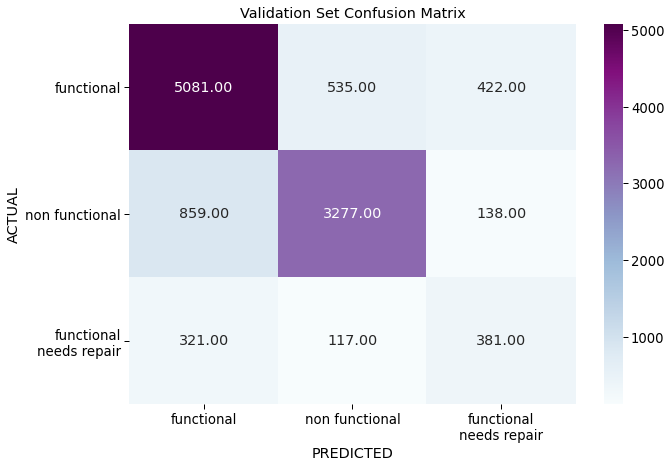

In [485]:
df_cm_val = pd.DataFrame(confusion_matx_val, index=labels, columns=labels)

sns.set_context("paper", font_scale=1.5)  
plt.figure(figsize = (10,7))

ax = sns.heatmap(df_cm_val, annot=True, fmt=".2f", cmap="BuPu")
ax.set(title="Validation Set Confusion Matrix",
       ylabel='ACTUAL',
       xlabel='PREDICTED')
ax.set_yticklabels(labels=['functional', 'non functional', 'functional\nneeds repair'], rotation=360)
ax.set_xticklabels(labels=['functional', 'non functional', 'functional\nneeds repair'], rotation=360);

From the confusion matrix, we can see that my current model is still predicting a lot of `functional needs repair` as `functional`. 

## Feature Importance

In [253]:
# OBTAIN FEATURE NAMES FROM PIPELINE
ohe_cols = pipe_sm[4].named_transformers_['cat'][0].get_feature_names(input_features=categorical_features)
num_cat = list(numerical_features) + list(ohe_cols)

In [321]:
feature_importances = pd.DataFrame({'feature': num_cat,
                                   'score': pipe_sm[6].feature_importances_})\
                        .sort_values(by='score', ascending=False)
feature_importances[:50]

,feature,score
8,longitude,0.102236
9,latitude,0.097462
10,nearest_big_city_distance,0.093025
87,quantity_dry,0.049730
1,gps_height,0.049213
5,age_recorded,0.042178
3,construction_year,0.038036
6,population,0.037009
88,quantity_enough,0.025093
65,extraction_type_class_other,0.020463


In [323]:
feature_importances[:50].score.sum()

0.8783253781677373

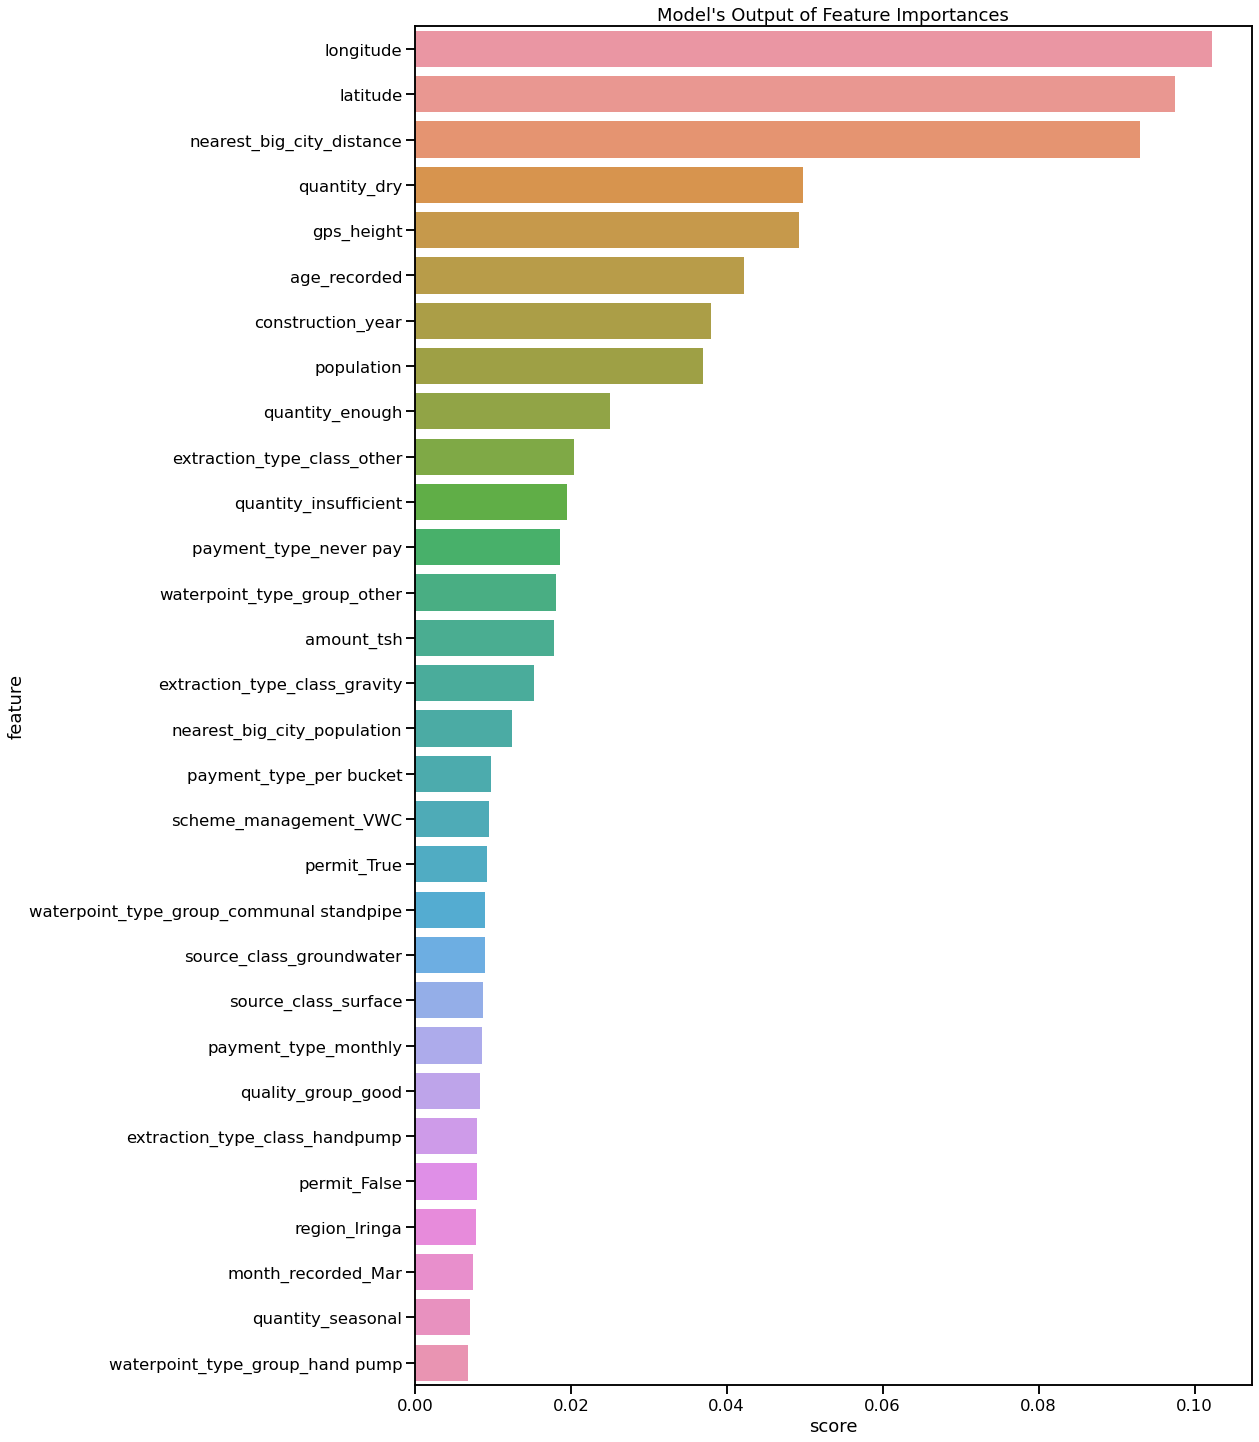

In [473]:
# FEATURE IMPORTANCES VISUALIZATION OF THE TOP 50 FEATURES
sns.set_context("talk") 
fig, ax = plt.subplots(1, figsize=(15, 25))
ax = sns.barplot(x='score', y='feature', data=feature_importances[:30])
ax.set_title("Model's Output of Feature Importances");

The top 10 most important features identified by my Random Forest Classifer model are:
1. `longitude`
2. `latitude`
3. `nearest_big_city_distance`
4. `quantity_dry`
5. `gps_height`
6. `age_recorded`
7. `construction_year`
8. `population`
9. `quantity_enough`
10. `extraction_type_class_other`

This results show that the location (`longitude`/`latitude`) of the waterpoints do contribute to their functionality signficantly. This could be due to various reasons, from natural climate, and or something more human-induced such as the lack of funding and/or maintenance.

And then we have the distance to nearest big city (with population over 100,000), which is one of the 3 additional features I created using external sources of data. 

`quantity` appears twice (with **dry** and **enough**), which are understandable. 

`gps_height`'s imporantance also corresponds with the visualizations in EDA above.

Other factors such as the age of the waterpoint, the `population` living nearby, and `payment_type` have also been found to be important.

### Feature Importance with a Random Feature

In order to verify the ranking of feature importance above, I will randomly generate data for another column called `random_feature`, which logically should not have any predictive power over `status_group`, therefore it should not be in the top/most important features. I'm curious where it would end up ranking in the feature importance list.

In [325]:
class AddRandom(BaseEstimator, TransformerMixin):
    """Add a randomly generated feature into the dataset
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        np.random.seed(seed=2021)
        X['random_feature'] = np.random.random(size = len(X))
        return self

Building new pipeline that includes the newly generated random feature:

In [326]:
# ADDING random_feature TO NUMERICAL FEATURES TO BE INCLUDED IN MODELING
numerical_features_rand = ['amount_tsh', 'gps_height', 'num_private', 'construction_year', 'year_recorded', 
                           'age_recorded', 'population', 'nearest_big_city_population', 'longitude', 
                           'latitude', 'nearest_big_city_distance', 'random_feature']


# ADDING RANDOM FEATURES INTO PIPELINE USING FeatureUnion
union_rand = FeatureUnion(transformer_list=[('recorded', DateTransformer()),
                                            ('nearest_big_city', FeatureGenerator()),
                                            ('random', AddRandom())])


# TRANSFORM NUMERICAL & CATEGORICAL FEATURES SEPARATELY USING ColumnTransformer
col_tranformer_rand = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features_rand),
                                                      ('cat', categorical_transformer, categorical_features)],
                                        remainder='drop')

In [327]:
# CREATE NEW FEATURES IN TRAINING SET X_tt
union_rand.fit_transform(X_tt_2)

array([DateTransformer(), FeatureGenerator(), AddRandom()], dtype=object)

In [331]:
# STACKING PREPROCESSOR TRANSFORMATIONS, SMOTE() AND RandomForestClassifier() 
# INTO AM IMBALANCE PIPELINE
pipe_sm_rand = imbPipeline([('fillna', NaNImputer()),
                            ('lng_imp', LongitudeImputer()),
                            ('funder', FunderBinner()),
                            ('installer', InstallerBinner()),
                            ('col_tf_rand', col_tranformer_rand),
                            ('sampler', SMOTE(random_state=2021, n_jobs=-1, 
                                              sampling_strategy='minority')),
                            ('rf', RandomForestClassifier(random_state=2021))])

In [332]:
# FIT MODEL ON THE TRAINING DATASET X_tt and y_tt
rf_rand = pipe_sm_rand.fit(X_tt_2, y_tt_2)

In [333]:
# OBTAIN FEATURE NAMES FROM PIPELINE
ohe_cols_rand = pipe_sm_rand[4].named_transformers_['cat'][0]\
                               .get_feature_names(input_features=categorical_features)
num_cat_rand = list(numerical_features_rand) + list(ohe_cols_rand)

# CREATE FEATURE IMPORTANCE DATAFRAME
feature_importances_rand = pd.DataFrame({'feature': num_cat_rand,
                                         'score': pipe_sm_rand[6].feature_importances_})\
                             .sort_values(by='score', ascending=False)
feature_importances_rand[:50]

,feature,score
8,longitude,0.090732
9,latitude,0.082455
10,nearest_big_city_distance,0.079156
11,random_feature,0.066375
88,quantity_dry,0.052649
1,gps_height,0.043932
5,age_recorded,0.039601
3,construction_year,0.037221
6,population,0.033189
89,quantity_enough,0.023518


`random_feature` ended up ranking fourth, above some features like `quantity_dry`, `extraction_type_class`, and `gps_height` which have all seem very prominent during the EDA process. I was expecting to use `random_feature` as the cut-off; however, this might not be a good idea in this scenario.

Further research on the topic has indicated that impurity-based feature importances have been known to be strongly biased and have the tendency to inflate continuous/high-cardinality features over low-cardinality features (binary/or categorical features with a smaller number of possible categories). That might be why `random_feature` ended up so high on the Random Forest Feature Importances.

Therefore, I'll look into this from another approach to see how the results would turn out. 

### Permutation Feature Importance

In this section, I will use Permutation Feature Importance to identify the most predictive variables that contribute to the overall accuracy score of my model the most. 

**Permutation Feature Importance** works by selecting a variable in the validation set, shuffling it randomly to destroy the correlation between that variable and all the other ones used for prediction, and then measuring the models performance on the shuffled validation dataset. 

If the performance drops significantly, that means the feature selected must have been importance. The only problem is that it's computational expensive, and takes a **long** time to execute.

In [358]:
# CREATE NEW FEATURES IN VALIDATION SET X_val
union.fit_transform(X_val)

array([DateTransformer(), FeatureGenerator()], dtype=object)

In [360]:
r = permutation_importance(rf2, X_val, y_val, n_repeats=10,
                           random_state=0)

In [368]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2*r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<8}: "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
        print()

quantity: 0.114 +/- 0.003

extraction_type_class: 0.031 +/- 0.003

waterpoint_type_group: 0.019 +/- 0.001

payment_type: 0.014 +/- 0.002

source_class: 0.009 +/- 0.002

population: 0.004 +/- 0.001

scheme_management: 0.004 +/- 0.002

quality_group: 0.003 +/- 0.001

management_group: 0.002 +/- 0.001

public_meeting: 0.002 +/- 0.001

num_private: 0.001 +/- 0.000



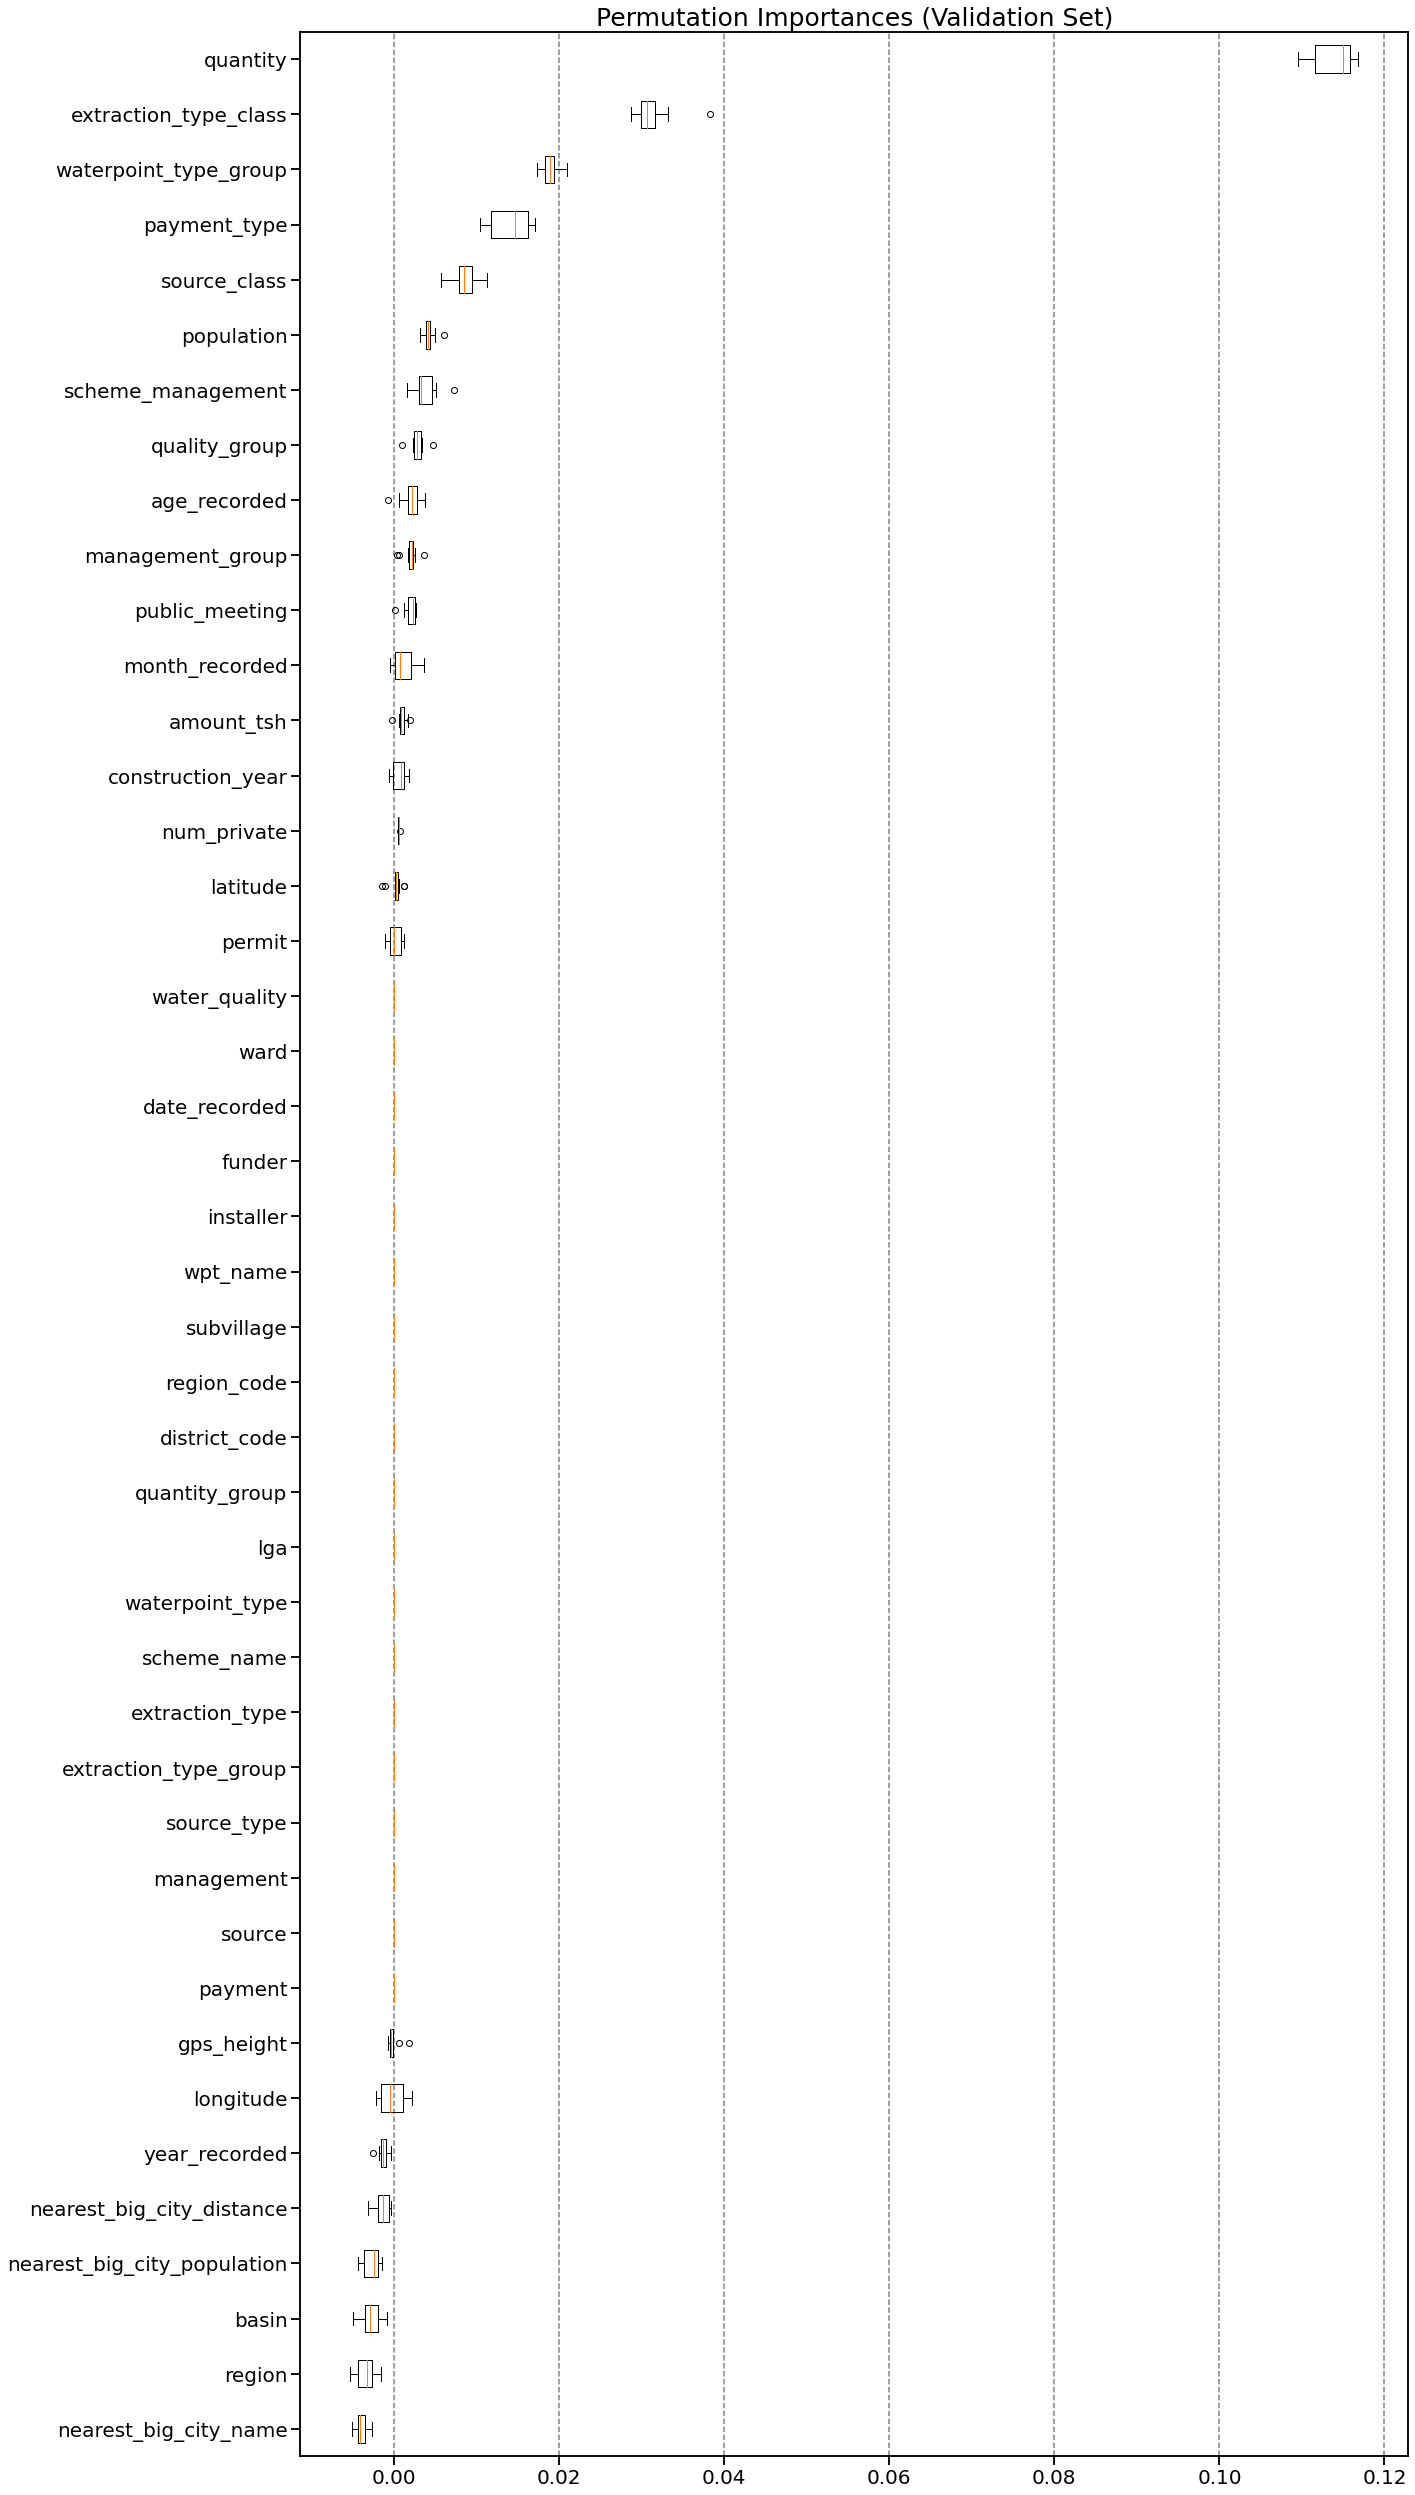

In [497]:
sorted_idx = r.importances_mean.argsort()

sns.set_context("talk") 

fig, ax = plt.subplots(figsize=(20,35))
ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=X_val.columns[sorted_idx])

# set title & font size
ax.set_title("Permutation Importances (Validation Set)", fontsize=25)

# reset font size for yticks
ax.tick_params(axis='both', which='major', labelsize=20)

# draw grid lines
ax.xaxis.grid(color='gray', linestyle='dashed')

fig.tight_layout()
plt.show()

In [383]:
# r_tt = permutation_importance(rf2, X_tt, y_tt, n_repeats=10,
#                               random_state=0)

Permutation Importance weeds out noises and features that might not be contributing significantly to the model.
- Looking at the plot above, we can see that on average, shuffling values in the `quantity` column would cause a drop of 11.4% in model performance. 
- On the other hand, breaking the connection between some features at the bottom of the charts (such as `nearest_big_city_name`, `region`, `basin`, etc.) seemed to have increased model performance.

I'm curious how a model WITHOUT any of the features from `permit` down would turn out.

### Dropping Features & Simplifying Model

In [463]:
# SELECT NUMERICAL FEATURES TO BE INCLUDED IN MODELING
numerical_features_perm = ['amount_tsh', 'num_private', 'construction_year',
                           'age_recorded', 'population', 'latitude']

# SELECT CATEGORICAL FEATURES TO BE INCLUDED IN MODELING
categorical_features_perm = ['public_meeting', 'scheme_management',
                             'permit', 'extraction_type_class', 'management_group', 'payment_type', 
                             'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']

In [464]:
# TRANSFORM NUMERICAL & CATEGORICAL FEATURES SEPARATELY USING ColumnTransformer
col_tranformer_perm = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features_perm),
                                                      ('cat', categorical_transformer, categorical_features_perm)],
                                        remainder='drop')

# STACKING PREPROCESSOR TRANSFORMATIONS, SMOTE() AND RandomForestClassifier() 
# INTO AM IMBALANCE PIPELINE
pipe_sm_perm = imbPipeline([('fillna', NaNImputer()),
                            ('lng_imp', LongitudeImputer()),
                            ('funder', FunderBinner()),
                            ('installer', InstallerBinner()),
                            ('col_tf_perm', col_tranformer_perm),
                            ('sampler', SMOTE(random_state=2021, n_jobs=-1, 
                                              sampling_strategy='minority')),
                            ('rf', RandomForestClassifier(random_state=2021))])

In [465]:
# FIT MODEL ON THE TRAINING DATASET X_tt and y_tt
rf_perm = pipe_sm_perm.fit(X_tt, y_tt)

In [466]:
# MAKE PREDICTIONS ON THE TRAINING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_tt_perm = rf_perm.predict(X_tt)
print(classification_report(y_tt, y_tt_perm))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     18112
functional needs repair       0.94      0.99      0.97      2412
         non functional       1.00      1.00      1.00     12868

               accuracy                           0.99     33392
              macro avg       0.98      0.99      0.99     33392
           weighted avg       0.99      0.99      0.99     33392



In [467]:
# MAKE PREDICTIONS ON THE VALIDATION DATASET 
y_val_perm = rf_perm.predict(X_val)
print(classification_report(y_val, y_val_perm))

                         precision    recall  f1-score   support

             functional       0.80      0.81      0.80      6038
functional needs repair       0.35      0.45      0.39       819
         non functional       0.80      0.75      0.77      4274

               accuracy                           0.76     11131
              macro avg       0.65      0.67      0.66     11131
           weighted avg       0.77      0.76      0.76     11131



Droping 26 columns (`water_quality`, `ward`, `date_recorded`, `funder`, `installer`, `wpt_name`, `subvillage`, `region_code`, `quality_group`, `lga`, `waterpoint_type`, `scheme_name`, `extraction_type`, `extraction_type_group`, `source_type`, `management`, `source`, `payment`, `gps_height`, `longitude`, `year_recorded`, `nearest_big_city_distance`, `nearest_big_city_population`, `basin`, `region`, and `nearest_big_city_name`) only brought the accuracy on validation set down from 78% to 76%, which means they're probably not contributing meaningfully to the target variable.

It also helps speed up execution time by reducing the total number of features down by 50% to 64 (from 128). This version is definitely simplier, and more interpretable. 

### Hyperparameter Tuning

In [479]:
# GRID SEARCH --> unsuccessful
param_grid = [{ 
    'rf__n_estimators': [200, 500],
    'rf__max_features': ['auto', 'sqrt', 'log2'], 
    'rf__max_depth' : [50, 100, 200],
    'rf__criterion' :['gini', 'entropy']
}]

pipe_sm_perm = imbPipeline([('fillna', NaNImputer()),
                            ('lng_imp', LongitudeImputer()),
                            ('funder', FunderBinner()),
                            ('installer', InstallerBinner()),
                            ('col_tf_perm', col_tranformer_perm),
                            ('sampler', SMOTE(random_state=2021, n_jobs=-1, 
                                              sampling_strategy='minority')),
                            ('rf', RandomForestClassifier(random_state=2021))])

gridsearch = GridSearchCV(estimator=pipe_sm_perm, param_grid=param_grid, 
                          scoring='accuracy', n_jobs=-1, cv=3, verbose=3)
gridsearch.fit(X_tt, y_tt)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 133.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('fillna', NaNImputer()),
                                       ('lng_imp', LongitudeImputer()),
                                       ('funder', FunderBinner()),
                                       ('installer', InstallerBinner()),
                                       ('col_tf_perm',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'num_private',
                                                                          'construction_year',
                                                                          'age_recorded'

### Random Forest Hyperparameter Tuning

After experimenting with different hyperparameters in the other exploratory notebooks, it seems like the only way for accuracy to go up is by increaseing `max_depth`. I am going to attempt to do GridSearch one more time on this more condensed model to see if it would yield different result.

In [480]:
gridsearch.best_score_

0.7493111938793979

In [481]:
gridsearch.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 100,
 'rf__max_features': 'log2',
 'rf__n_estimators': 500}

The highest accuracy score that GridSearch was able to get from trying out 36 different combinations of hyperparameters is 74.93%, which is still lower than the score I was able to get by using Random Forest with its default settings (76%).

Although the final model that I have selected did not achieve the highest accuracy score, it contains less features and simpler to interpret. Since the goal for this section of my project is mainly to get a better understanding of the factors that might affect the functionality outcome of well pumps in Tanzania, this simple model has helped weed out some variables such as `basin` and `region`, and shift our focus to `extraction_type_class`, `waterpoint_type`, `payment_type`, etc, which can all be monitored, controlled and improved upon by human. 

Next, I am going to fit my model on the whole training dataset, and then test it on the testing dataset to see if the outcomes would change much from the training/validation sets.

### Model Evaluation

In [477]:
# CREATE NEW FEATURES IN MASTER TRAINING SET X_train
union.fit_transform(X_train)

array([DateTransformer(), FeatureGenerator()], dtype=object)

In [482]:
# FIT MODEL ON THE TRAINING DATASET X_tt and y_tt
rf_perm = pipe_sm_perm.fit(X_train, y_train)

In [483]:
# MAKE PREDICTIONS ON THE TRAINING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_train_perm = rf_perm.predict(X_train)
print(classification_report(y_train, y_train_perm))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24150
functional needs repair       0.94      0.99      0.96      3231
         non functional       1.00      1.00      1.00     17142

               accuracy                           0.99     44523
              macro avg       0.98      0.99      0.99     44523
           weighted avg       0.99      0.99      0.99     44523



In [484]:
# CREATE NEW FEATURES IN MASTER TESTING SET X_test
union.fit_transform(X_test)

# MAKE PREDICTIONS ON THE TESTING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_test_perm = rf_perm.predict(X_test)
print(classification_report(y_test, y_test_perm))

                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      8087
functional needs repair       0.33      0.46      0.38      1083
         non functional       0.80      0.75      0.78      5671

               accuracy                           0.75     14841
              macro avg       0.64      0.67      0.65     14841
           weighted avg       0.77      0.75      0.76     14841



In [486]:
confusion_matx_test = confusion_matrix(y_test, y_test_perm, labels=labels)
confusion_matx_test

array([[6444,  906,  737],
       [1127, 4266,  278],
       [ 436,  153,  494]])

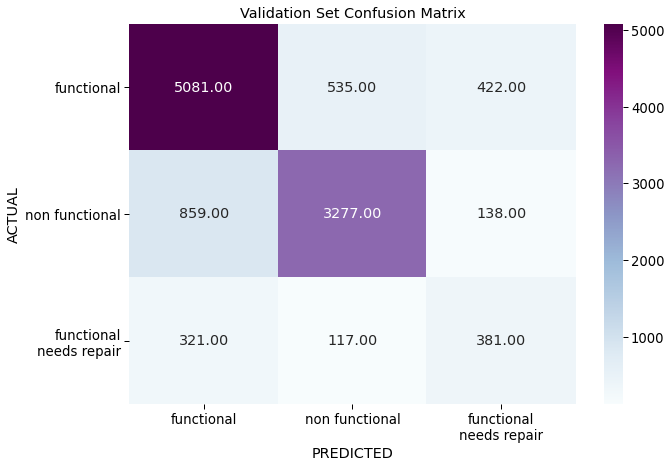

In [487]:
df_cm_test = pd.DataFrame(confusion_matx_test, index=labels, columns=labels)

sns.set_context("paper", font_scale=1.5)  
plt.figure(figsize = (10,7))

ax = sns.heatmap(df_cm_val, annot=True, fmt=".2f", cmap="BuPu")
ax.set(title="Validation Set Confusion Matrix",
       ylabel='ACTUAL',
       xlabel='PREDICTED')
ax.set_yticklabels(labels=['functional', 'non functional', 'functional\nneeds repair'], rotation=360)
ax.set_xticklabels(labels=['functional', 'non functional', 'functional\nneeds repair'], rotation=360);

### Feature Importances of Simplified Model

In [468]:
# OBTAIN FEATURE NAMES FROM PIPELINE
ohe_cols_perm = pipe_sm_perm[4].named_transformers_['cat'][0]\
                               .get_feature_names(input_features=categorical_features_perm)
num_cat_perm = list(numerical_features_perm) + list(ohe_cols_perm)

# CREATE FEATURE IMPORTANCE DATAFRAME
feature_importances_perm = pd.DataFrame({'feature': num_cat_perm,
                                         'score': pipe_sm_perm[6].feature_importances_})\
                             .sort_values(by='score', ascending=False)
feature_importances_perm[:50]

,feature,score
5,latitude,0.283926
3,age_recorded,0.086956
4,population,0.081874
2,construction_year,0.069950
50,quantity_dry,0.057659
0,amount_tsh,0.032270
51,quantity_enough,0.022148
28,extraction_type_class_other,0.020862
25,extraction_type_class_gravity,0.019438
52,quantity_insufficient,0.019165


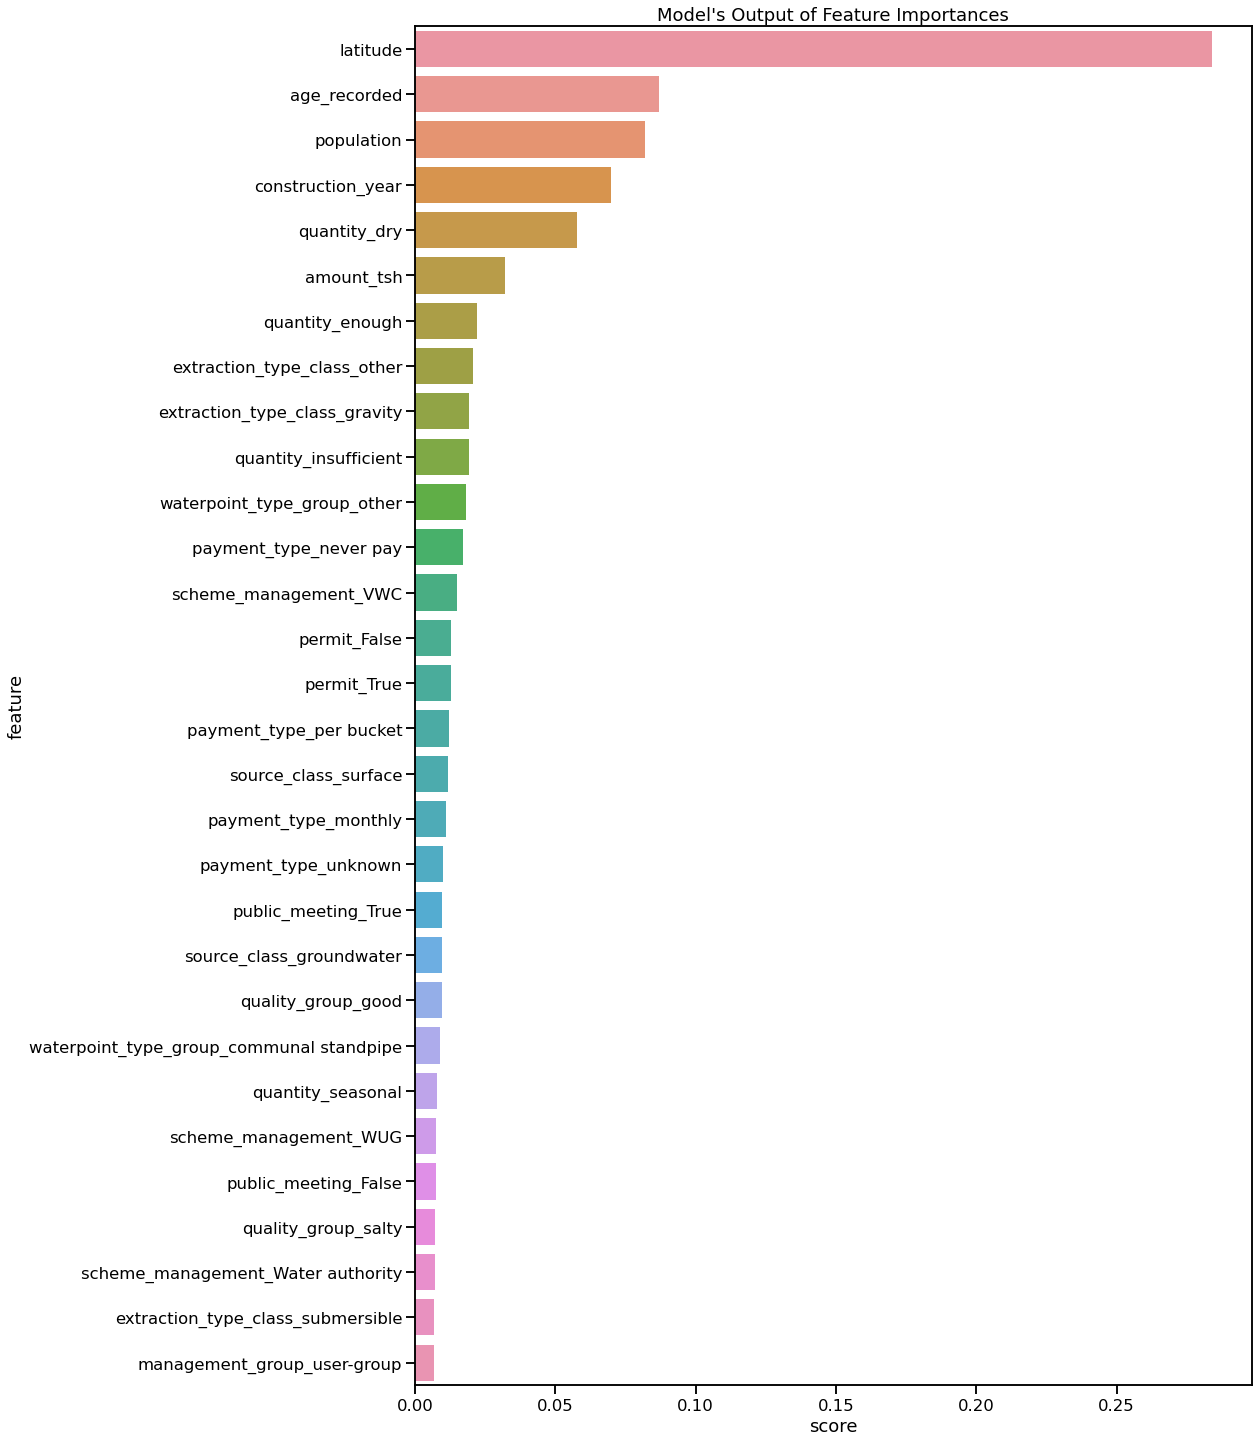

In [472]:
# FEATURE IMPORTANCES VISUALIZATION OF THE TOP 30 FEATURES
sns.set_context("talk") 
fig, ax = plt.subplots(1, figsize=(15, 25))
ax = sns.barplot(x='score', y='feature', data=feature_importances_perm[:30])
ax.set_title("Model's Output of Feature Importances");

## Competition Model Adjustments

The goal for the competition model is slightly different from the interpretation above. Instead of trying to understand what might be influencing the functionality outcomes of water pumps in Tanzania, I would be focusing more on maximizing accuracy score. 

Therefore, for my first model in this section, I would include all numeric features in the dataset. In addition, I would also convert `date_recorded` to numeric.

In [518]:
class DateTransformer_2(BaseEstimator, TransformerMixin):
    """Extracts information from datetime column to create new features

    Returns:
        - month_recorded: first 3 character of name of the month recorded
        - year_recorded: four-digit year
        - age_recorded: difference between construction year and year recorded
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Convert date_recorded to datetime object
        X['date_recorded'] = pd.to_datetime(X['date_recorded'])
        
        # Extract month_ and year_recorded
        X['month_recorded'] = X.date_recorded.dt.month_name().str.slice(stop=3)
        X['year_recorded'] = X.date_recorded.dt.year
        X['age_recorded'] = X['year_recorded'] - X['construction_year']
        
        # Convert datetime object to numeric
        X['date_recorded'] = pd.to_numeric(X['date_recorded'])
        return self

In [521]:
# ADDING NEW FEATURES USING FeatureUnion
union_comp = FeatureUnion(transformer_list=[('recorded', DateTransformer_2())])

In [522]:
union_comp.fit_transform(X_tt_comp)

array([DateTransformer_2()], dtype=object)

In [549]:
# SELECT NUMERICAL FEATURES TO BE INCLUDED IN MODELING
numerical_features_all = list(X_tt_comp.select_dtypes(exclude=[object]).columns)

In [563]:
# SELECT CATEGORICAL FEATURES TO BE INCLUDED IN MODELING
categorical_features_comp = ['funder', 'installer', 'basin', 'region', 'public_meeting', 'scheme_management',
                             'permit', 'extraction_type_class', 'management_group', 'payment_type', 
                             'quality_group', 'quantity', 'source_class', 'waterpoint_type_group', 
                             'month_recorded']

In [551]:
# TRANSFORM NUMERICAL & CATEGORICAL FEATURES SEPARATELY USING ColumnTransformer
col_tranformer_comp = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features_all),
                                                      ('cat', categorical_transformer, categorical_features_comp)],
                                        remainder='drop')

#### Random Forest with SMOTE

In [552]:
# PIPELINE WITH SMOTE()
pipe_sm_comp = imbPipeline([('fillna', NaNImputer()),
                            ('lng_imp', LongitudeImputer()),
                            ('funder', FunderBinner()),
                            ('installer', InstallerBinner()),
                            ('col_tf_comp', col_tranformer_comp),
                            ('sampler', SMOTE(random_state=2021, n_jobs=-1, 
                                              sampling_strategy='minority')),
                            ('rf', RandomForestClassifier(random_state=2021))])

In [553]:
scores_comp1 = cross_val_score(pipe_sm_comp, X_tt_comp, y_tt_comp, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      3623
functional needs repair       0.42      0.41      0.41       483
         non functional       0.82      0.75      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.67      0.67      6679
           weighted avg       0.78      0.78      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      3623
functional needs repair       0.44      0.42      0.43       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.69      0.68      0.68      6679
           weighted avg       0.79      0.79      0.79      6679

                         precision    recall  f1-score   support

             funct

In [555]:
print(f'Cross Validation Accuracy Scores: {scores_comp1}')
print()
print(f'Average Accuracy: {scores_comp1.mean()}')

Cross Validation Accuracy Scores: [0.78080551 0.7872436  0.78301887 0.78361785 0.77912549]

Average Accuracy: 0.7827622626801694


In [556]:
# max_depth = 200
pipe_sm_comp = imbPipeline([('fillna', NaNImputer()),
                            ('lng_imp', LongitudeImputer()),
                            ('funder', FunderBinner()),
                            ('installer', InstallerBinner()),
                            ('col_tf_comp', col_tranformer_comp),
                            ('sampler', SMOTE(random_state=2021, n_jobs=-1, 
                                              sampling_strategy='minority')),
                            ('rf', RandomForestClassifier(random_state=2021, max_depth=200))])

scores_comp2 = cross_val_score(pipe_sm_comp, X_tt_comp, y_tt_comp, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      3623
functional needs repair       0.42      0.41      0.41       483
         non functional       0.82      0.75      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.67      0.67      6679
           weighted avg       0.78      0.78      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      3623
functional needs repair       0.44      0.42      0.43       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.69      0.68      0.68      6679
           weighted avg       0.79      0.79      0.79      6679

                         precision    recall  f1-score   support

             funct

In [557]:
print(f'Cross Validation Accuracy Scores: {scores_comp2}')
print()
print(f'Average Accuracy: {scores_comp2.mean()}')

Cross Validation Accuracy Scores: [0.78080551 0.7872436  0.78301887 0.78361785 0.77912549]

Average Accuracy: 0.7827622626801694


Since the first model that I trained above without using SMOTE seemed to have higher accuracy score, I woulld remove SMOTE and try a similar version here to see if that's going to improve my performance in general.

In [559]:
# STACKING THEM TOGETHER IN A PIPELINE
preprocessor_comp = Pipeline(steps=[('fillna', NaNImputer()),
                                    ('lng_imp', LongitudeImputer()),
                                    ('funder', FunderBinner()),
                                    ('installer', InstallerBinner()),
                                    ('col_tf_comp', col_tranformer_comp)])

# STACKING preprocessor AND RandomForestClassifier() INTO A PIPELINE
pipeline_comp = Pipeline(steps=[('preprocessor', preprocessor_comp),
                                ('rf', RandomForestClassifier(random_state=2021))])

scores_rf_comp = cross_val_score(pipeline_comp, X_tt_comp, y_tt_comp, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      3623
functional needs repair       0.48      0.32      0.38       483
         non functional       0.82      0.76      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.70      0.65      0.67      6679
           weighted avg       0.78      0.79      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      3623
functional needs repair       0.52      0.33      0.41       483
         non functional       0.81      0.78      0.80      2573

               accuracy                           0.80      6679
              macro avg       0.71      0.66      0.68      6679
           weighted avg       0.79      0.80      0.79      6679

                         precision    recall  f1-score   support

             funct

In [560]:
print(f'Cross Validation Accuracy Scores: {scores_rf_comp}')
print()
print(f'Average Accuracy: {scores_rf_comp.mean()}')

Cross Validation Accuracy Scores: [0.78784249 0.79592753 0.78945792 0.78721174 0.78691225]

Average Accuracy: 0.7894703872409268


In [561]:
scores_rf_comp.mean() - scores_comp1.mean()

0.0067081245607574225

Accuracy has gone up a little bit (by 0.67%) just by removing SMOTE; therefore, I am going to keep heading in this direction, although Recall Score on `functional needs repair` is relatively low.

Next, I am going to try a different Scaler method (Standard Scaler) to see if that'd produce any changes in accuracy if any.

In [564]:
# DEFINE TRANSFORMER USING StandardScaler()
ss_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# TRANSFORM NUMERICAL & CATEGORICAL FEATURES SEPARATELY USING ColumnTransformer
col_tranformer_comp2 = ColumnTransformer(transformers=[('num', ss_transformer, numerical_features_all),
                                                       ('cat', categorical_transformer, categorical_features_comp)],
                                         remainder='drop')

# STACKING THEM TOGETHER IN A PIPELINE
preprocessor_comp2 = Pipeline(steps=[('fillna', NaNImputer()),
                                     ('lng_imp', LongitudeImputer()),
                                     ('funder', FunderBinner()),
                                     ('installer', InstallerBinner()),
                                     ('col_tf_comp2', col_tranformer_comp2)])

# STACKING preprocessor AND RandomForestClassifier() INTO A PIPELINE
pipeline_comp2 = Pipeline(steps=[('preprocessor', preprocessor_comp2),
                                 ('rf', RandomForestClassifier(random_state=2021))])

scores_rf_comp2 = cross_val_score(pipeline_comp2, X_tt_comp, y_tt_comp, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      3623
functional needs repair       0.49      0.32      0.39       483
         non functional       0.82      0.76      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.70      0.65      0.67      6679
           weighted avg       0.78      0.79      0.78      6679

                         precision    recall  f1-score   support

             functional       0.80      0.86      0.83      3623
functional needs repair       0.53      0.33      0.41       483
         non functional       0.81      0.78      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.72      0.66      0.68      6679
           weighted avg       0.79      0.79      0.79      6679

                         precision    recall  f1-score   support

             funct

In [565]:
print(f'Cross Validation Accuracy Scores: {scores_rf_comp2}')
print()
print(f'Average Accuracy: {scores_rf_comp2.mean()}')

Cross Validation Accuracy Scores: [0.78859111 0.79413086 0.7900569  0.78900869 0.78571429]

Average Accuracy: 0.7895003677159519


In [566]:
# STACKING preprocessor AND RandomForestClassifier() INTO A PIPELINE
pipeline_comp2 = Pipeline(steps=[('preprocessor', preprocessor_comp2),
                                 ('rf', RandomForestClassifier(random_state=2021,
                                                               n_estimators=300))])

scores_rf_comp2 = cross_val_score(pipeline_comp2, X_tt_comp, y_tt_comp, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.79      0.87      0.83      3623
functional needs repair       0.48      0.32      0.38       483
         non functional       0.81      0.76      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.70      0.65      0.67      6679
           weighted avg       0.78      0.79      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      3623
functional needs repair       0.54      0.34      0.41       483
         non functional       0.82      0.79      0.80      2573

               accuracy                           0.80      6679
              macro avg       0.72      0.66      0.68      6679
           weighted avg       0.79      0.80      0.79      6679

                         precision    recall  f1-score   support

             funct

In [567]:
print(f'Cross Validation Accuracy Scores: {scores_rf_comp2}')
print()
print(f'Average Accuracy: {scores_rf_comp2.mean()}')

Cross Validation Accuracy Scores: [0.78664471 0.79952089 0.79260258 0.7884097  0.78661276]

Average Accuracy: 0.7907581262176204


In [570]:
# FIT MODEL ON THE WHOLE X_tt, y_tt SET
comp_model = pipeline_comp2.fit(X_tt_comp, y_tt_comp)

In [575]:
# MAKE PREDICTIONS ON THE TRAINING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_tt_comp_pred = comp_model.predict(X_tt_comp)
print(classification_report(y_tt_comp, y_tt_comp_pred))

                         precision    recall  f1-score   support

             functional       0.94      0.98      0.96     18112
functional needs repair       0.92      0.78      0.84      2412
         non functional       0.97      0.94      0.96     12868

               accuracy                           0.95     33392
              macro avg       0.95      0.90      0.92     33392
           weighted avg       0.95      0.95      0.95     33392



In [577]:
# TRANSFORM 'date_recorded' COLUMN IN VALIDATION DATASET
union_comp.transform(X_val_comp)

array([DateTransformer_2()], dtype=object)

In [578]:
# MAKE PREDICTIONS ON VALIDATION DATASET X_val
y_val_comp_pred = comp_model.predict(X_val_comp)
print(classification_report(y_val_comp, y_val_comp_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.89      0.84      6038
functional needs repair       0.54      0.29      0.38       819
         non functional       0.84      0.76      0.80      4274

               accuracy                           0.80     11131
              macro avg       0.72      0.65      0.67     11131
           weighted avg       0.79      0.80      0.79     11131



In [579]:
# TRANSFORM 'date_recorded' COLUMN IN THE WHOLE MASTER TRAINING DATASET
union_comp.transform(X_train_comp)

array([DateTransformer_2()], dtype=object)

In [580]:
# FIT MODEL ON THE WHOLE X_train_comp, y_train_comp SET
comp_model = pipeline_comp2.fit(X_train_comp, y_train_comp)

In [581]:
# MAKE PREDICTIONS ON THE MASTER TRAINING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_train_comp_pred = comp_model.predict(X_train_comp)
print(classification_report(y_train_comp, y_train_comp_pred))

                         precision    recall  f1-score   support

             functional       0.90      0.98      0.94     24150
functional needs repair       0.91      0.64      0.75      3231
         non functional       0.96      0.89      0.92     17142

               accuracy                           0.92     44523
              macro avg       0.92      0.84      0.87     44523
           weighted avg       0.92      0.92      0.92     44523



In [582]:
# TRANSFORM 'date_recorded' COLUMN IN THE WHOLE MASTER TRAINING DATASET
union_comp.transform(X_test_comp)

# MAKE PREDICTIONS ON THE TESTING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_test_comp_pred = comp_model.predict(X_test_comp)
print(classification_report(y_test_comp, y_test_comp_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      8087
functional needs repair       0.46      0.32      0.38      1083
         non functional       0.82      0.78      0.80      5671

               accuracy                           0.80     14841
              macro avg       0.70      0.66      0.67     14841
           weighted avg       0.79      0.80      0.79     14841



In [583]:
# TRANSFORM 'date_recorded' COLUMN IN THE WHOLE MASTER DATASET
union_comp.transform(X)

array([DateTransformer_2()], dtype=object)

In [584]:
# FIT MODEL ON THE WHOLE X_master, y_master SET
comp_model = pipeline_comp2.fit(X, y)

In [585]:
# MAKE PREDICTIONS ON THE MASTER TRAINING DATASET 
# & PRINT OUT CLASSIFICATION REPORT

y_master_pred = comp_model.predict(X_master)
print(classification_report(y_master, y_master_pred))

                         precision    recall  f1-score   support

             functional       0.90      0.97      0.93     32237
functional needs repair       0.90      0.64      0.75      4314
         non functional       0.95      0.89      0.92     22813

               accuracy                           0.92     59364
              macro avg       0.92      0.83      0.87     59364
           weighted avg       0.92      0.92      0.92     59364



In [605]:
# EXTRACT ids FROM FINAL TEST (FOR COMPETITION SUBMISSION LATER)
ids = final_test.id
final_test = final_test.drop(['recorded_by', 'id'], axis=1)

In [598]:
# TRANSFORM 'date_recorded' COLUMN IN THE final_test SET
union_comp.transform(final_test)

array([DateTransformer_2()], dtype=object)

In [600]:
# MAKE PREDICTIONS FOR THE final_test SET
final_pred = comp_model.predict(final_test)

In [609]:
# CONVERT PREDICTIONS TO A pandas DATAFRAME FOR COMPETITION SUBMISSION
final_pred_df = pd.DataFrame({'id': ids, 'status_group': final_pred})
final_pred_df.set_index('id', inplace=True)

In [611]:
# SAVE PREDICTIONS AS .csv
directory_to_pred = os.path.join('..', '..', 'predictions')

final_pred_df.to_csv(os.path.join(directory_to_pred, 'y_pred.csv'))

This prediction received an accuracy score of **81.11%**, which which is currently ranked the 1983th. The highest accuracy score on the Leaderboard to date is **82.94%**. Let's look at the Feature Importances of the Competition Model:

In [612]:
# OBTAIN FEATURE NAMES FROM PIPELINE
ohe_cols_comp = pipeline_comp2[0][4].named_transformers_['cat'][0]\
                               .get_feature_names(input_features=categorical_features_comp)
num_cat_comp = list(numerical_features_all) + list(ohe_cols_comp)

# CREATE FEATURE IMPORTANCE DATAFRAME
feature_importances_comp = pd.DataFrame({'feature': num_cat_comp,
                                         'score': pipeline_comp2[1].feature_importances_})\
                             .sort_values(by='score', ascending=False)
feature_importances_comp[:50]

,feature,score
3,longitude,0.124902
4,latitude,0.124097
90,quantity_dry,0.071107
1,date_recorded,0.063647
2,gps_height,0.060765
8,population,0.042195
11,age_recorded,0.037302
9,construction_year,0.036432
103,waterpoint_type_group_other,0.029788
91,quantity_enough,0.026462


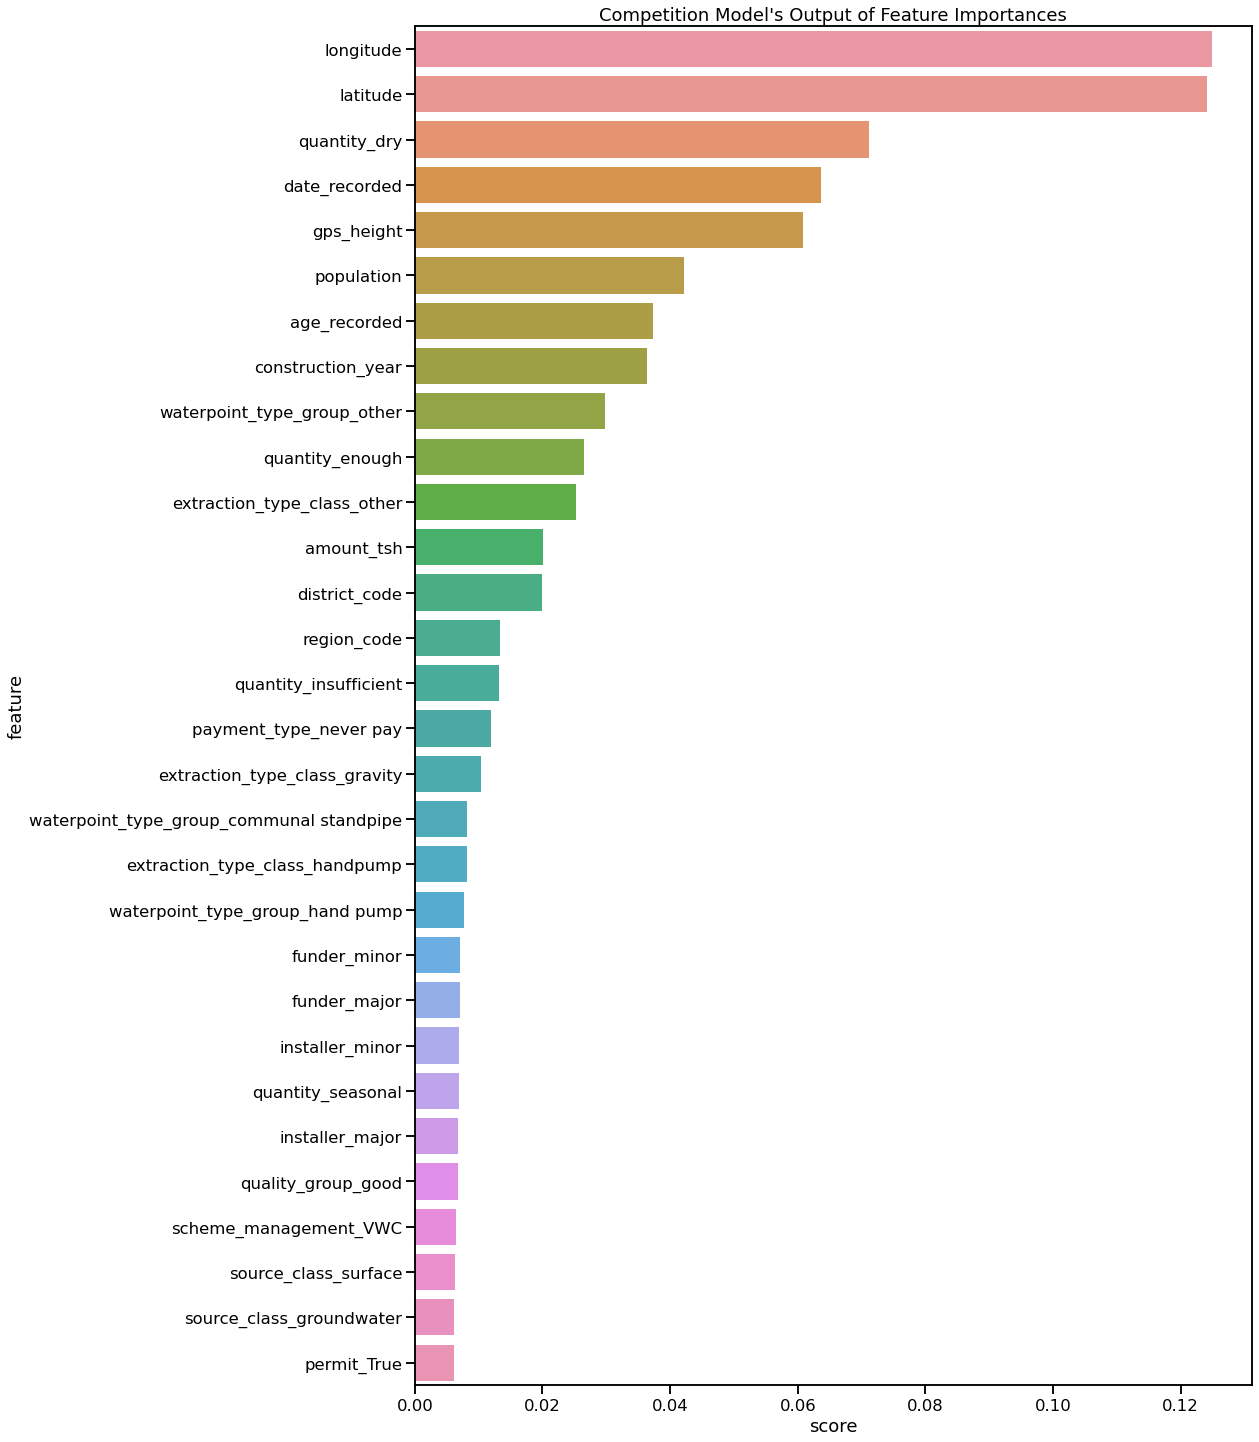

In [613]:
# FEATURE IMPORTANCES VISUALIZATION OF THE TOP 30 FEATURES
sns.set_context("talk") 
fig, ax = plt.subplots(1, figsize=(15, 25))
ax = sns.barplot(x='score', y='feature', data=feature_importances_comp[:30])
ax.set_title("Competition Model's Output of Feature Importances");

## Conclusions



## Next Steps

One thing I've noticed when comparing 2 models is that although both models are overfitting to the training dataset, the gap between training & testing accuracy scores in the first model is around 24% (99% in training and 75% in testing), while that gap in the competition model is around 12% (92% in training and 80% in testing). 

The major difference between the 2 pipelines is that the inferential model utilizes SMOTE (with the goal of increasing Recall Score for less represented class), while competition model doesn't. Overfitting could be the result of hyperparameter settings in oversampling of the minority class, which caused the model to overcorrect, and not perform as well when class frequencies change (from training to testing data). For our next steps, it is worth experimenting with different hyperparameter settings for SMOTE as well as other oversampling method (such as ADASYN) to see if there is a combination that might reduce overfitting.